In this notebook we will visualize the fiber products that occur in The Residual Finiteness of $A_{2,3,2n}$ Triangle Artin Groups by Greyson Meyer.

In [1]:
import tkinter as tkinter
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

# The Functions

The fiber_product function calculates the fiber product of two graphs that combinatorially immerse into $\tilde{U}$.

In [2]:
def fiber_product(graph1, graph2):

  new_x_arrows = []
  new_y_arrows = []
  new_d_arrows = []
  new_vertices = []

  # Here we find the x arrows that arise in the fiber product
  for arrow in graph1[0]:
    for other_arrow in graph2[0]:

      first_value = (arrow[0],other_arrow[0])
      second_value = (arrow[1],other_arrow[1])
      new_x_arrow = (first_value, second_value)
      new_x_arrows.append(new_x_arrow)

      if first_value not in new_vertices:
        new_vertices.append(first_value)

      if second_value not in new_vertices:
        new_vertices.append(second_value)

  # Here we find the y arrows that arise in the fiber product
  for arrow in graph1[1]:
    for other_arrow in graph2[1]:

      first_value = (arrow[0],other_arrow[0])
      second_value = (arrow[1],other_arrow[1])
      new_y_arrow = (first_value, second_value)
      new_y_arrows.append(new_y_arrow)

      if first_value not in new_vertices:
        new_vertices.append(first_value)

      if second_value not in new_vertices:
        new_vertices.append(second_value)

  # Here we find the delta arrows that arise in the fiber product
  for arrow in graph1[2]:
    for other_arrow in graph2[2]:

      first_value = (arrow[0],other_arrow[0])
      second_value = (arrow[1],other_arrow[1])
      new_d_arrow = (first_value, second_value)
      new_d_arrows.append(new_d_arrow)

      if first_value not in new_vertices:
        new_vertices.append(first_value)

      if second_value not in new_vertices:
        new_vertices.append(second_value)

  new_graph = [new_x_arrows, new_y_arrows, new_d_arrows, new_vertices]
  return new_graph

We display the graph using Python's networkx package.

In [188]:
def draw_graph(graph, ax=None):

    x_arrows, y_arrows, d_arrows, vertices = graph

    G = nx.MultiDiGraph()
    G.add_nodes_from(vertices)

    for u,v in x_arrows:
        G.add_edge(u, v, color="red")
    for u,v in y_arrows:
        G.add_edge(u, v, color="green")
    for u,v in d_arrows:
        G.add_edge(u, v, color="yellow")

    colors = [data["color"] for u,v,k,data in G.edges(data=True, keys=True)]
    pos = nx.circular_layout(G)

    if ax is None:
        plt.figure(figsize=(8,8))
        ax = plt.gca()

    nx.draw_networkx_nodes(G, pos, node_color="blue", node_size=500, ax=ax)

    label_pos = {}
    label_offset = 0.0
    for node, (x, y) in pos.items():
        label_pos[node] = (x, y + label_offset)

    nx.draw_networkx_labels(
    G, label_pos,
    labels={n: str(n) if type(n) == int else str(n[1] % 10) for n in G.nodes()},
    font_color="white",
    font_size=10,
    ax=ax
)


    for (u,v,k), c in zip(G.edges(keys=True), colors):
        if c == "green":
            rad = 0.1
        elif c == "yellow":
            rad = -0.1  # negative curvature to avoid overlap with green edges
        else:
            rad = 0.0
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u,v)],
            edge_color=c,
            connectionstyle=f'arc3,rad={rad}',
            arrows=True,
            arrowstyle='-|>',
            arrowsize=20,
            width=2,
            ax=ax
        )

    ax.axis("off")
    return pos, G


Later on we will want to display the calculated graph alongside the graph from the paper that is its supergraph. To do this, we use the following function.

In [4]:
def display_graph_with_image(graph, image, description):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Draw the graph in the left subplot
    pos, G = draw_graph(graph, ax=axes[0])

    # Image + description in the right subplot
    axes[1].imshow(image)
    axes[1].axis("off")
    axes[1].set_title(description, fontsize=12)

    plt.show()

Computing the fiber product of two graphs often results in many connected components. The find_incidence function below returns all of the vertices in "graph" that share an edge with "vertex". This will be a key tool used to isolate connected components of fiber products later on.

In [5]:
def find_incidence (vertex, graph):

  x_edges = graph[0]
  y_edges = graph[1]
  d_edges = graph[2]
  incidence = []

  for j in x_edges:
    if vertex == j[0] and j[1] not in incidence:
      incidence.append(j[1])
    if vertex == j[1] and j[0] not in incidence:
      incidence.append(j[0])
    for j in y_edges:
      if vertex == j[0] and j[1] not in incidence:
        incidence.append(j[1])
      if vertex == j[1] and j[0] not in incidence:
        incidence.append(j[0])
    for j in d_edges:
      if vertex == j[0] and j[1] not in incidence:
        incidence.append(j[1])
      if vertex == j[1] and j[0] not in incidence:
        incidence.append(j[0])
        
  return incidence

The split function below returns a dictionary of the connected components present in "graph". We are only interested in connected components that have more than one vertex since $\sigma(W)$ contains no length-one loops, forcing every connected component that combinatorially immerses into $\sigma(W)$ with one vertex to be homotopically trivial.

In [172]:
def split(graph):

  x_edges = graph[0]
  y_edges = graph[1]
  d_edges = graph[2]
  vertices = graph[3]
  d = dict()

  # for each vertex it puts all of the vertices in the connected component containing that vertex in the 3rd position, including the vertex itself
  for i in vertices:
    d[i] = [[], [], [], []]
    d[i][3] = find_incidence(i, graph)
    d[i][3].append(i)

  # All of the edges touching that vertex are added to the other indices of d[k]
  for k in d:
    for edge in x_edges:
      if k == edge[0] or k == edge[1]:
        d[k][0].append(edge)

    for edge in y_edges:
      if k == edge[0] or k == edge[1]:
        d[k][1].append(edge)

    for edge in d_edges:
      if k == edge[0] or k == edge[1]:
        d[k][2].append(edge)

# This is where we find the redundant elements of the dictionary and mark them for deletion
  keys_to_delete = []
  for j in vertices:
    for k in vertices:
      # if j and k both share vertices, that means that they are part of the same connected component. So j absorbs all of k's edge info and then k is later deleted.
      if (j != k) and (len(set(d[j][3]) & set(d[k][3])) != 0):
        d[j][0] = list(set(d[j][0]) | set(d[k][0]))
        d[j][1] = list(set(d[j][1]) | set(d[k][1]))
        d[j][2] = list(set(d[j][2]) | set(d[k][2]))
        d[j][3] = list(set(d[j][3]) | set(d[k][3]))
        d[k][3] = []
        keys_to_delete.append(k)

  for i in keys_to_delete:
    del d[i]
    
  return d

Everybody likes dictionaries with readable keys! The readable_keys function below does well to keep us all sane.

In [7]:
def readable_keys(d):
  # Replaces the dictionary keys with numbers to make the prompt in check_fiber easier to understand

  better_d = dict()
  key_list = list(d.keys())
  for key in key_list:
    key_index = key_list.index(key)
    better_d[key_index] = d[key]
  return better_d

The what_subgraph function below tells us which column of Table 1 in the paper that an inputted connected component "graph" belongs. The criteria for deciding which column is somewhat arbitrary since there are connected components that arise in the calculations that can be viewed as a subgraph of a number of the relevant graphs in Table 1, and thus could theoretically occupy multiple cells at once. The author has checked by hand that what_subgraph does indeed properly classify all connected components that arise in the fiber products in the paper.

In [8]:
def what_subgraph(graph):
  # Classifies each connected component as being a subgraph of one of the non q-contractible graphs, or else classifies the graph as
  # q-contractible. This function was not used to prove that no new non q-contractible connected components arise. The author proved that
  # by going through every connected component by hand. This function is simply to be used to partition the connected components after the
  # lack of new non q-contractible connected components has already been established.

  green_edges = graph[1]
  red_edges = graph[0]
  rgbigons = []

  for green in green_edges:
    for red in red_edges:
      if ((green[1] == red[0]) and (green[0] == red[1])):
        rgbigons.append([green, red])
  
  # If the connected component has exactly one red-green bigon, it is considered to be a subgraph of Y_1
  if len(rgbigons) == 1:
    return [1, 'Y1']
  
  if len(rgbigons) > 1:
    bigon1 = rgbigons[0]
    bigon2 = rgbigons[1]
    green1 = bigon1[0]
    green2 = bigon2[0]

    # If there are two connected red-green bigons, then the graph is considered to be a subgraph of sigma(W)
    if ((green1[1] == green2[0]) or (green2[1] == green1[0])):
      return [0, 'sigma(W)']
    
    checker = 0

    # If there is a green edge, then a red edge attached to a red-green bigon, then the graph is considered to be a subgraph of Y_1
    for green in green_edges:
      if green1[1] == green[0]:
        for red in red_edges:
          if red[0] == green[1]:
            checker = 1
            return [1, 'Y1']
    
    # Any other graph containing multiple red-green bigons is considered to be a subgraph of \beta(Y_1)
    if checker == 0:
      return [2, 'bY1']
    
  # Checks for the length-10 loop that both Y2 and Y3 have, and then decides whether the graph is a subgraph of Y_2 or Y_3
  for green in green_edges:
    if green[0][1] % 10 == 2:
      for red in red_edges:
        if red[0] == green[1]:
          for red2 in red_edges:
            if red2[0] == red[1]:
              for green2 in green_edges:
                if green2[1] == red2[1]:
                  for red3 in red_edges:
                    if red3[0] == green2[0]:
                      for green3 in green_edges:
                        if green3[1] == red3[1]:
                          for red4 in red_edges:
                            if red4[0] == green3[0]:
                              for red5 in red_edges:
                                if red5[0] == red4[1]:
                                  for green4 in green_edges:
                                    if green4[0] == red5[1]:
                                      for red6 in red_edges:
                                        if red6[1] == green4[1]:
                                          if red6[0] == green[0]:
                                            if len(green_edges) == 4:
                                              return [3, 'Y2']
                                            else:
                                              two_counter = 0
                                              for green5 in green_edges:
                                                if green5[0][1] % 10 == 2:
                                                  two_counter += 1
                                              if two_counter == 4:
                                                return [3, 'Y2']
                                              else:
                                                return [4, 'Y3']

  # Checks for the length-12 loop that Y_2 and \beta(Y_3) have. The previous block takes care of the full copies of Y_2, 
  # and any subgraphs of Y_2 containing this loop are also subgraphs of \beta(Y_3), so we choose to label it bY3
  for green in green_edges:
    if green[0][1] % 10 == 2:
      for red in red_edges:
        if red[0] == green[1]:
          for red2 in red_edges:
            if red2[0] == red[1]:
              for green2 in green_edges:
                if green2[0] == red2[1]:
                  for green3 in green_edges:
                    if green3[0] == green2[1]:
                      for red3 in red_edges:
                        if red3[0] == green3[1]:
                          for green4 in green_edges:
                            if green4[1] == red3[1]:
                              for red4 in red_edges:
                                if red4[0] == green4[0]:
                                  for red5 in red_edges:
                                    if red5[0] == red4[1]:
                                      for green5 in green_edges:
                                        if green5[1] == red5[1]:
                                          for green6 in green_edges:
                                            if green6[1] == green5[0]:
                                              for red6 in red_edges:
                                                if ((red6[1] == green6[0]) and (red6[0] == green[0])):
                                                  return [5, 'bY3']

  # Checks for the length-12 loop that Y_3 has
  for green in green_edges:
    if green[0][1] % 10 == 1:
      for red in red_edges:
        if red[1] == green[1]:
          for green2 in green_edges:
            if green2[1] == red[0]:
              for green3 in green_edges:
                if green3[1] == green2[0]:
                  for red2 in red_edges:
                    if red2[0] == green3[0]:
                      for red3 in red_edges:
                        if red3[0] == red2[1]:
                          for green4 in green_edges:
                            if green4[1] == red3[1]:
                              for red4 in red_edges:
                                if red4[0] == green4[0]:
                                  for green5 in green_edges:
                                    if green5[0] == red4[1]:
                                      for green6 in green_edges:
                                        if green6[0] == green5[1]:
                                          for red5 in red_edges:
                                            if red5[0] == green6[1]:
                                              for red6 in red_edges:
                                                if red6[0] == red5[1]:
                                                  if red6[1] == green[0]:
                                                    return [4, 'Y3']

  return [6, 'q-contractible']

The check_row function is used to populate the rows of the table in the paper by applying what_subgraph to every connected component that rises from the fiber product of graph1 and graph2. This was used to double check the author's work, not prove anything.

In [9]:
def check_row(graph1, graph2):
  
  row = [0, 0, 0, 0, 0, 0, 0]
  new = fiber_product(graph1,graph2)
  new_split = split(new)
  just_red = 0
  sub_of_triangle = 0
  interesting_list = []

  for key in new_split.keys():
    g = new_split[key]
    if (len(g[1]) == 0 and len(g[2]) == 0):
      just_red += 1
    elif len(g[0]) == 0 and len(g[1]) <= 3:
      sub_of_triangle += 1
    else:
      interesting_list.append(g)

  for component in interesting_list:
    info = what_subgraph(component)
    index = info[0]
    row[index] += 1

  row[6] += just_red + sub_of_triangle
  return row

Y4_x_Y4 is really large, so we have a special version of check_row made for Y4_x_Y4. The only substantive difference is that the fiber product is not calculated within the function. Instead we feed in the already calculated Y4_x_Y4 to save time.

In [10]:
Y4_x_Y4 = {0: [[((22, 22), (23, 23)), ((13, 13), (11, 11)), ((21, 21), (24, 24)), ((2, 2), (3, 3)), ((34, 34), (32, 32)), ((31, 31), (34, 34)), ((33, 33), (31, 31)), ((23, 23), (21, 21)), ((11, 11), (14, 14)), ((14, 14), (12, 12)), ((12, 12), (13, 13)), ((32, 32), (33, 33)), ((1, 1), (4, 4)), ((3, 3), (1, 1)), ((24, 24), (22, 22)), ((4, 4), (2, 2))], [((12, 12), (31, 31)), ((41, 41), (33, 33)), ((11, 11), (3, 3)), ((42, 42), (11, 11)), ((3, 3), (42, 42)), ((2, 2), (21, 21)), ((33, 33), (22, 22)), ((22, 22), (41, 41))], [((12, 12), (31, 31)), ((41, 41), (33, 33)), ((11, 11), (3, 3)), ((42, 42), (11, 11)), ((3, 3), (42, 42)), ((2, 2), (21, 21)), ((33, 33), (22, 22)), ((22, 22), (41, 41))], [(13, 13), (22, 22), (33, 33), (32, 32), (42, 42), (2, 2), (41, 41), (34, 34), (11, 11), (4, 4), (23, 23), (14, 14), (1, 1), (3, 3), (21, 21), (12, 12), (31, 31), (24, 24)]], 1: [[((4, 2), (2, 3)), ((2, 3), (3, 1)), ((1, 4), (4, 2)), ((3, 1), (1, 4))], [((2, 3), (21, 42))], [((2, 3), (21, 42))], [(2, 3), (21, 42), (1, 4), (3, 1), (4, 2)]], 2: [[((3, 4), (1, 2)), ((2, 1), (3, 4)), ((4, 3), (2, 1)), ((1, 2), (4, 3))], [], [], [(1, 2), (2, 1), (3, 4), (4, 3)]], 3: [[((2, 4), (3, 2)), ((4, 1), (2, 4)), ((3, 2), (1, 3)), ((1, 3), (4, 1))], [((3, 2), (42, 21))], [((3, 2), (42, 21))], [(42, 21), (2, 4), (4, 1), (3, 2), (1, 3)]], 4: [[((4, 14), (2, 12)), ((21, 31), (24, 34)), ((22, 32), (23, 33)), ((24, 34), (22, 32)), ((3, 13), (1, 11)), ((23, 33), (21, 31)), ((2, 12), (3, 13)), ((1, 11), (4, 14))], [((2, 12), (21, 31))], [((2, 12), (21, 31))], [(23, 33), (1, 11), (3, 13), (21, 31), (22, 32), (2, 12), (4, 14), (24, 34)]], 5: [[((1, 14), (4, 12)), ((2, 13), (3, 11)), ((4, 12), (2, 13)), ((3, 11), (1, 14))], [((42, 3), (11, 42)), ((11, 42), (3, 11)), ((3, 11), (42, 3))], [((42, 3), (11, 42)), ((11, 42), (3, 11)), ((3, 11), (42, 3))], [(11, 42), (42, 3), (1, 14), (4, 12), (2, 13), (3, 11)]], 6: [[((2, 11), (3, 14)), ((24, 1), (22, 4)), ((23, 2), (21, 3)), ((4, 13), (2, 11)), ((21, 3), (24, 1)), ((1, 12), (4, 13)), ((3, 14), (1, 12)), ((22, 4), (23, 2))], [((2, 11), (21, 3))], [((2, 11), (21, 3))], [(1, 12), (3, 14), (4, 13), (24, 1), (21, 3), (22, 4), (23, 2), (2, 11)]], 7: [[((4, 11), (2, 14)), ((1, 13), (4, 11)), ((2, 14), (3, 12)), ((3, 12), (1, 13))], [((3, 12), (42, 31))], [((3, 12), (42, 31))], [(2, 14), (1, 13), (3, 12), (4, 11), (42, 31)]], 8: [[((1, 21), (4, 24)), ((4, 24), (2, 22)), ((3, 23), (1, 21)), ((2, 22), (3, 23))], [((2, 22), (21, 41))], [((2, 22), (21, 41))], [(2, 22), (4, 24), (1, 21), (3, 23), (21, 41)]], 9: [[((13, 4), (11, 2)), ((14, 3), (12, 1)), ((1, 24), (4, 22)), ((11, 2), (14, 3)), ((4, 22), (2, 23)), ((2, 23), (3, 21)), ((12, 1), (13, 4)), ((3, 21), (1, 24))], [((11, 2), (3, 21))], [((11, 2), (3, 21))], [(13, 4), (12, 1), (2, 23), (1, 24), (4, 22), (11, 2), (14, 3), (3, 21)]], 10: [[((2, 21), (3, 24)), ((1, 22), (4, 23)), ((4, 23), (2, 21)), ((3, 24), (1, 22))], [], [], [(3, 24), (4, 23), (2, 21), (1, 22)]], 11: [[((1, 23), (4, 21)), ((2, 24), (3, 22)), ((12, 34), (13, 32)), ((14, 31), (12, 34)), ((11, 33), (14, 31)), ((3, 22), (1, 23)), ((13, 32), (11, 33)), ((4, 21), (2, 24))], [((3, 22), (42, 41)), ((42, 41), (11, 33)), ((11, 33), (3, 22))], [((3, 22), (42, 41)), ((42, 41), (11, 33)), ((11, 33), (3, 22))], [(2, 24), (42, 41), (4, 21), (13, 32), (1, 23), (3, 22), (12, 34), (14, 31), (11, 33)]], 12: [[((4, 34), (2, 32)), ((1, 31), (4, 34)), ((3, 33), (1, 31)), ((2, 32), (3, 33))], [((11, 41), (3, 33)), ((3, 33), (42, 22)), ((42, 22), (11, 41))], [((11, 41), (3, 33)), ((3, 33), (42, 22)), ((42, 22), (11, 41))], [(1, 31), (3, 33), (42, 22), (2, 32), (11, 41), (4, 34)]], 13: [[((1, 34), (4, 32)), ((12, 11), (13, 14)), ((23, 24), (21, 22)), ((32, 4), (33, 2)), ((22, 21), (23, 24)), ((33, 2), (31, 3)), ((34, 1), (32, 4)), ((4, 32), (2, 33)), ((11, 12), (14, 13)), ((21, 22), (24, 23)), ((24, 23), (22, 21)), ((3, 31), (1, 34)), ((13, 14), (11, 12)), ((2, 33), (3, 31)), ((14, 13), (12, 11)), ((31, 3), (34, 1))], [((2, 33), (21, 22)), ((12, 11), (31, 3)), ((11, 12), (3, 31)), ((33, 2), (22, 21))], [((2, 33), (21, 22)), ((12, 11), (31, 3)), ((11, 12), (3, 31)), ((33, 2), (22, 21))], [(2, 33), (34, 1), (1, 34), (4, 32), (21, 22), (14, 13), (33, 2), (31, 3), (12, 11), (3, 31), (13, 14), (22, 21), (24, 23), (32, 4), (11, 12), (23, 24)]], 14: [[((1, 32), (4, 33)), ((2, 31), (3, 34)), ((3, 34), (1, 32)), ((4, 33), (2, 31))], [], [], [(1, 32), (2, 31), (4, 33), (3, 34)]], 15: [[((1, 33), (4, 31)), ((2, 34), (3, 32)), ((3, 32), (1, 33)), ((4, 31), (2, 34))], [], [], [(4, 31), (3, 32), (2, 34), (1, 33)]], 16: [[((3, 103), (1, 101)), ((31, 121), (34, 124)), ((32, 122), (33, 123)), ((2, 102), (3, 103)), ((33, 123), (31, 121)), ((14, 134), (12, 132)), ((34, 124), (32, 122)), ((23, 113), (21, 111)), ((4, 104), (2, 102)), ((1, 101), (4, 104)), ((11, 131), (14, 134)), ((21, 111), (24, 114)), ((12, 132), (13, 133)), ((13, 133), (11, 131)), ((24, 114), (22, 112)), ((22, 112), (23, 113))], [((2, 102), (21, 111)), ((12, 132), (31, 121)), ((33, 123), (22, 112)), ((11, 131), (3, 103))], [((2, 102), (21, 111)), ((12, 132), (31, 121)), ((33, 123), (22, 112)), ((11, 131), (3, 103))], [(12, 132), (1, 101), (3, 103), (32, 122), (24, 114), (34, 124), (13, 133), (23, 113), (11, 131), (21, 111), (2, 102), (14, 134), (4, 104), (22, 112), (31, 121), (33, 123)]], 17: [[((1, 104), (4, 102)), ((3, 101), (1, 104)), ((2, 103), (3, 101)), ((4, 102), (2, 103))], [], [], [(4, 102), (1, 104), (2, 103), (3, 101)]], 18: [[((4, 103), (2, 101)), ((2, 101), (3, 104)), ((1, 102), (4, 103)), ((3, 104), (1, 102))], [], [], [(1, 102), (3, 104), (4, 103), (2, 101)]], 19: [[((1, 103), (4, 101)), ((2, 104), (3, 102)), ((3, 102), (1, 103)), ((4, 101), (2, 104))], [((11, 143), (3, 102)), ((42, 111), (11, 143)), ((3, 102), (42, 111))], [((11, 143), (3, 102)), ((42, 111), (11, 143)), ((3, 102), (42, 111))], [(2, 104), (42, 111), (1, 103), (3, 102), (4, 101), (11, 143)]], 20: [[((2, 112), (3, 113)), ((1, 111), (4, 114)), ((4, 114), (2, 112)), ((3, 113), (1, 111))], [], [], [(2, 112), (4, 114), (1, 111), (3, 113)]], 21: [[((14, 103), (12, 101)), ((2, 113), (3, 111)), ((3, 111), (1, 114)), ((11, 102), (14, 103)), ((4, 112), (2, 113)), ((13, 104), (11, 102)), ((1, 114), (4, 112)), ((12, 101), (13, 104))], [((42, 143), (11, 102)), ((11, 102), (3, 111)), ((3, 111), (42, 143))], [((42, 143), (11, 102)), ((11, 102), (3, 111)), ((3, 111), (42, 143))], [(13, 104), (2, 113), (4, 112), (1, 114), (11, 102), (14, 103), (42, 143), (12, 101), (3, 111)]], 22: [[((4, 113), (2, 111)), ((3, 114), (1, 112)), ((1, 112), (4, 113)), ((2, 111), (3, 114))], [((2, 111), (21, 143))], [((2, 111), (21, 143))], [(3, 114), (4, 113), (21, 143), (2, 111), (1, 112)]], 23: [[((2, 114), (3, 112)), ((1, 113), (4, 111)), ((14, 121), (12, 124)), ((3, 112), (1, 113)), ((11, 123), (14, 121)), ((12, 124), (13, 122)), ((13, 122), (11, 123)), ((4, 111), (2, 114))], [((11, 123), (3, 112))], [((11, 123), (3, 112))], [(4, 111), (13, 122), (1, 113), (3, 112), (12, 124), (14, 121), (11, 123), (2, 114)]], 24: [[((3, 123), (1, 121)), ((1, 121), (4, 124)), ((2, 122), (3, 123)), ((4, 124), (2, 122))], [((3, 123), (42, 112))], [((3, 123), (42, 112))], [(2, 122), (4, 124), (1, 121), (3, 123), (42, 112)]], 25: [[((4, 122), (2, 123)), ((33, 102), (31, 103)), ((21, 112), (24, 113)), ((23, 114), (21, 112)), ((24, 113), (22, 111)), ((3, 121), (1, 124)), ((14, 133), (12, 131)), ((2, 123), (3, 121)), ((11, 132), (14, 133)), ((31, 103), (34, 101)), ((13, 134), (11, 132)), ((22, 111), (23, 114)), ((32, 104), (33, 102)), ((34, 101), (32, 104)), ((1, 124), (4, 122)), ((12, 131), (13, 134))], [((12, 131), (31, 103)), ((42, 153), (11, 132)), ((41, 143), (33, 102)), ((2, 123), (21, 112)), ((3, 121), (42, 153)), ((22, 111), (41, 143)), ((33, 102), (22, 111)), ((11, 132), (3, 121))], [((12, 131), (31, 103)), ((42, 153), (11, 132)), ((41, 143), (33, 102)), ((2, 123), (21, 112)), ((3, 121), (42, 153)), ((22, 111), (41, 143)), ((33, 102), (22, 111)), ((11, 132), (3, 121))], [(2, 123), (11, 132), (4, 122), (32, 104), (1, 124), (21, 112), (42, 153), (34, 101), (3, 121), (41, 143), (22, 111), (14, 133), (24, 113), (31, 103), (33, 102), (13, 134), (12, 131), (23, 114)]], 26: [[((1, 122), (4, 123)), ((2, 121), (3, 124)), ((3, 124), (1, 122)), ((4, 123), (2, 121))], [((2, 121), (21, 153))], [((2, 121), (21, 153))], [(21, 153), (1, 122), (2, 121), (4, 123), (3, 124)]], 27: [[((4, 121), (2, 124)), ((1, 123), (4, 121)), ((3, 122), (1, 123)), ((2, 124), (3, 122))], [], [], [(3, 122), (2, 124), (4, 121), (1, 123)]], 28: [[((21, 121), (24, 124)), ((1, 131), (4, 134)), ((4, 134), (2, 132)), ((24, 124), (22, 122)), ((23, 123), (21, 121)), ((2, 132), (3, 133)), ((3, 133), (1, 131)), ((22, 122), (23, 123))], [((2, 132), (21, 121))], [((2, 132), (21, 121))], [(23, 123), (1, 131), (3, 133), (2, 132), (21, 121), (4, 134), (22, 122), (24, 124)]], 29: [[((4, 132), (2, 133)), ((2, 133), (3, 131)), ((1, 134), (4, 132)), ((3, 131), (1, 134))], [((3, 131), (42, 103))], [((3, 131), (42, 103))], [(2, 133), (42, 103), (4, 132), (3, 131), (1, 134)]], 30: [[((23, 102), (21, 103)), ((22, 104), (23, 102)), ((24, 101), (22, 104)), ((21, 103), (24, 101)), ((4, 133), (2, 131)), ((1, 132), (4, 133)), ((3, 134), (1, 132)), ((2, 131), (3, 134))], [((2, 131), (21, 103))], [((2, 131), (21, 103))], [(21, 103), (22, 104), (23, 102), (1, 132), (3, 134), (2, 131), (4, 133), (24, 101)]], 31: [[((1, 133), (4, 131)), ((2, 134), (3, 132)), ((3, 132), (1, 133)), ((4, 131), (2, 134))], [((42, 121), (11, 153)), ((11, 153), (3, 132)), ((3, 132), (42, 121))], [((42, 121), (11, 153)), ((11, 153), (3, 132)), ((3, 132), (42, 121))], [(3, 132), (1, 133), (4, 131), (42, 121), (11, 153), (2, 134)]], 32: [[((4, 204), (2, 212)), ((3, 203), (1, 211)), ((2, 212), (3, 203)), ((23, 233), (21, 251)), ((1, 211), (4, 204))], [((3, 203), (42, 202)), ((42, 202), (11, 201)), ((2, 212), (21, 251)), ((11, 201), (3, 203))], [((3, 203), (42, 202)), ((11, 201), (3, 203)), ((2, 212), (21, 251))], [(21, 251), (1, 211), (3, 203), (42, 202), (2, 212), (4, 204), (11, 201), (23, 233)]], 33: [[((4, 212), (2, 203)), ((1, 204), (4, 212)), ((2, 203), (3, 211)), ((3, 211), (1, 204))], [((42, 213), (11, 222)), ((11, 222), (3, 211)), ((2, 203), (21, 202))], [((42, 213), (11, 222)), ((11, 222), (3, 211)), ((2, 203), (21, 202))], [(11, 222), (2, 203), (4, 212), (1, 204), (21, 202), (42, 213), (3, 211)]], 34: [[((4, 203), (2, 211)), ((2, 211), (3, 204)), ((3, 204), (1, 212)), ((1, 212), (4, 203))], [], [], [(3, 204), (4, 203), (1, 212), (2, 211)]], 35: [[((1, 203), (4, 211)), ((2, 204), (3, 212)), ((3, 212), (1, 203)), ((4, 211), (2, 204))], [((3, 212), (42, 251))], [((3, 212), (42, 251))], [(42, 251), (1, 203), (3, 212), (2, 204), (4, 211)]], 36: [[((1, 232), (4, 213))], [], [], [(4, 213), (1, 232)]], 37: [[((3, 223), (1, 221)), ((4, 214), (2, 252)), ((2, 252), (3, 223)), ((1, 221), (4, 214))], [((3, 223), (42, 242)), ((2, 252), (21, 241)), ((42, 242), (11, 231)), ((11, 231), (3, 223))], [((3, 223), (42, 242)), ((2, 252), (21, 241)), ((11, 231), (3, 223))], [(2, 252), (1, 221), (3, 223), (21, 241), (11, 231), (4, 214), (42, 242)]], 38: [[((2, 223), (3, 221)), ((11, 232), (14, 213)), ((4, 252), (2, 223)), ((1, 214), (4, 252)), ((3, 221), (1, 214))], [((2, 223), (21, 242)), ((11, 232), (3, 221))], [((2, 223), (21, 242)), ((11, 232), (3, 221))], [(2, 223), (11, 232), (14, 213), (1, 214), (3, 221), (4, 252), (21, 242)]], 39: [[((1, 252), (4, 223)), ((3, 214), (1, 252)), ((4, 223), (2, 221)), ((2, 221), (3, 214))], [], [], [(2, 221), (4, 223), (1, 252), (3, 214)]], 40: [[((4, 221), (2, 214)), ((2, 214), (3, 252)), ((11, 233), (14, 251)), ((1, 223), (4, 221)), ((3, 252), (1, 223))], [((42, 241), (11, 233)), ((3, 252), (42, 241))], [((42, 241), (11, 233)), ((3, 252), (42, 241))], [(42, 241), (3, 252), (14, 251), (1, 223), (4, 221), (11, 233), (2, 214)]], 41: [[((1, 233), (4, 251))], [], [], [(4, 251), (1, 233)]], 42: [[((4, 232), (2, 213))], [((2, 213), (21, 222))], [((2, 213), (21, 222))], [(21, 222), (2, 213), (4, 232)]], 43: [[((4, 233), (2, 251))], [], [], [(2, 251), (4, 233)]], 44: [[((33, 233), (31, 251)), ((23, 223), (21, 221)), ((11, 211), (14, 204)), ((21, 221), (24, 214)), ((14, 204), (12, 212)), ((13, 203), (11, 211)), ((22, 252), (23, 223)), ((2, 232), (3, 213)), ((24, 214), (22, 252)), ((12, 212), (13, 203))], [((22, 252), (41, 241)), ((3, 213), (42, 222)), ((12, 212), (31, 251)), ((41, 241), (33, 233)), ((2, 232), (21, 221)), ((42, 222), (11, 211))], [((22, 252), (41, 241)), ((3, 213), (42, 222)), ((12, 212), (31, 251)), ((41, 241), (33, 233)), ((2, 232), (21, 221)), ((42, 222), (11, 211))], [(14, 204), (22, 252), (2, 232), (3, 213), (13, 203), (42, 222), (31, 251), (21, 221), (12, 212), (41, 241), (11, 211), (33, 233), (24, 214), (23, 223)]], 45: [[((13, 204), (11, 212)), ((14, 203), (12, 211)), ((12, 211), (13, 204)), ((11, 212), (14, 203)), ((2, 233), (3, 251))], [((11, 212), (3, 251))], [((11, 212), (3, 251))], [(14, 203), (11, 212), (3, 251), (2, 233), (12, 211), (13, 204)]], 46: [[((3, 232), (1, 213))], [((3, 232), (42, 221))], [((3, 232), (42, 221))], [(3, 232), (42, 221), (1, 213)]], 47: [[((3, 233), (1, 251))], [((11, 241), (3, 233)), ((42, 252), (11, 241))], [((11, 241), (3, 233)), ((42, 252), (11, 241))], [(3, 233), (1, 251), (11, 241), (42, 252)]], 48: [[((33, 23), (31, 21)), ((31, 21), (34, 24)), ((13, 3), (11, 1)), ((12, 2), (13, 3)), ((14, 4), (12, 2)), ((34, 24), (32, 22)), ((11, 1), (14, 4)), ((32, 22), (33, 23))], [((12, 2), (31, 21))], [((12, 2), (31, 21))], [(11, 1), (33, 23), (14, 4), (13, 3), (12, 2), (32, 22), (34, 24), (31, 21)]], 49: [[((13, 1), (11, 4)), ((11, 4), (14, 2)), ((14, 2), (12, 3)), ((12, 3), (13, 1))], [((12, 3), (31, 42))], [((12, 3), (31, 42))], [(13, 1), (11, 4), (14, 2), (31, 42), (12, 3)]], 50: [[((13, 2), (11, 3)), ((12, 4), (13, 2)), ((14, 1), (12, 4)), ((11, 3), (14, 1))], [((3, 42), (42, 11)), ((11, 3), (3, 42)), ((42, 11), (11, 3))], [((3, 42), (42, 11)), ((11, 3), (3, 42)), ((42, 11), (11, 3))], [(12, 4), (14, 1), (11, 3), (3, 42), (42, 11), (13, 2)]], 51: [[((14, 12), (12, 13)), ((11, 14), (14, 12)), ((12, 13), (13, 11)), ((13, 11), (11, 14))], [], [], [(14, 12), (11, 14), (12, 13), (13, 11)]], 52: [[((12, 14), (13, 12)), ((14, 11), (12, 14)), ((13, 12), (11, 13)), ((11, 13), (14, 11))], [], [], [(13, 12), (11, 13), (12, 14), (14, 11)]], 53: [[((12, 22), (13, 23)), ((13, 23), (11, 21)), ((11, 21), (14, 24)), ((14, 24), (12, 22))], [((12, 22), (31, 41)), ((42, 2), (11, 21))], [((12, 22), (31, 41)), ((42, 2), (11, 21))], [(14, 24), (12, 22), (11, 21), (13, 23), (31, 41), (42, 2)]], 54: [[((13, 21), (11, 24)), ((11, 24), (14, 22)), ((12, 23), (13, 21)), ((14, 22), (12, 23))], [], [], [(12, 23), (14, 22), (11, 24), (13, 21)]], 55: [[((12, 21), (13, 24)), ((13, 24), (11, 22)), ((14, 23), (12, 21)), ((11, 22), (14, 23))], [((3, 41), (42, 33)), ((11, 22), (3, 41)), ((42, 33), (11, 22))], [((3, 41), (42, 33)), ((11, 22), (3, 41)), ((42, 33), (11, 22))], [(14, 23), (11, 22), (12, 21), (3, 41), (42, 33), (13, 24)]], 56: [[((13, 22), (11, 23)), ((12, 24), (13, 22)), ((14, 21), (12, 24)), ((11, 23), (14, 21))], [], [], [(11, 23), (13, 22), (12, 24), (14, 21)]], 57: [[((12, 32), (13, 33)), ((11, 31), (14, 34)), ((13, 33), (11, 31)), ((14, 34), (12, 32))], [((42, 12), (11, 31))], [((42, 12), (11, 31))], [(11, 31), (13, 33), (14, 34), (42, 12), (12, 32)]], 58: [[((33, 24), (31, 22)), ((34, 23), (32, 21)), ((14, 32), (12, 33)), ((32, 21), (33, 24)), ((31, 22), (34, 23)), ((11, 34), (14, 32)), ((13, 31), (11, 34)), ((12, 33), (13, 31))], [((12, 33), (31, 22))], [((12, 33), (31, 22))], [(12, 33), (32, 21), (34, 23), (14, 32), (11, 34), (31, 22), (13, 31), (33, 24)]], 59: [[((14, 33), (12, 31)), ((13, 34), (11, 32)), ((12, 31), (13, 34)), ((11, 32), (14, 33))], [], [], [(14, 33), (12, 31), (11, 32), (13, 34)]], 60: [[((14, 104), (12, 102)), ((32, 112), (33, 113)), ((33, 113), (31, 111)), ((11, 101), (14, 104)), ((12, 102), (13, 103)), ((34, 114), (32, 112)), ((31, 111), (34, 114)), ((13, 103), (11, 101))], [((12, 102), (31, 111))], [((12, 102), (31, 111))], [(33, 113), (14, 104), (13, 103), (12, 102), (32, 112), (34, 114), (11, 101), (31, 111)]], 61: [[((12, 103), (13, 101)), ((13, 101), (11, 104)), ((14, 102), (12, 103)), ((11, 104), (14, 102))], [], [], [(14, 102), (11, 104), (12, 103), (13, 101)]], 62: [[((13, 102), (11, 103)), ((14, 101), (12, 104)), ((11, 103), (14, 101)), ((12, 104), (13, 102))], [((42, 131), (11, 103))], [((42, 131), (11, 103))], [(13, 102), (11, 103), (42, 131), (12, 104), (14, 101)]], 63: [[((14, 114), (12, 112)), ((12, 112), (13, 113)), ((13, 113), (11, 111)), ((11, 111), (14, 114))], [((11, 111), (3, 143)), ((3, 143), (42, 102)), ((42, 102), (11, 111))], [((11, 111), (3, 143)), ((3, 143), (42, 102)), ((42, 102), (11, 111))], [(14, 114), (3, 143), (13, 113), (42, 102), (12, 112), (11, 111)]], 64: [[((12, 113), (13, 111)), ((14, 112), (12, 113)), ((13, 111), (11, 114)), ((11, 114), (14, 112))], [], [], [(12, 113), (14, 112), (11, 114), (13, 111)]], 65: [[((14, 113), (12, 111)), ((12, 111), (13, 114)), ((13, 114), (11, 112)), ((11, 112), (14, 113))], [((12, 111), (31, 143)), ((42, 123), (11, 112))], [((12, 111), (31, 143)), ((42, 123), (11, 112))], [(31, 143), (14, 113), (42, 123), (12, 111), (11, 112), (13, 114)]], 66: [[((14, 111), (12, 114)), ((11, 113), (14, 111)), ((13, 112), (11, 113)), ((12, 114), (13, 112))], [], [], [(11, 113), (13, 112), (12, 114), (14, 111)]], 67: [[((14, 124), (12, 122)), ((12, 122), (13, 123)), ((13, 123), (11, 121)), ((11, 121), (14, 124))], [((11, 121), (3, 153)), ((42, 132), (11, 121)), ((3, 153), (42, 132))], [((11, 121), (3, 153)), ((42, 132), (11, 121)), ((3, 153), (42, 132))], [(14, 124), (13, 123), (12, 122), (11, 121), (3, 153), (42, 132)]], 68: [[((14, 122), (12, 123)), ((32, 111), (33, 114)), ((33, 114), (31, 112)), ((11, 124), (14, 122)), ((12, 123), (13, 121)), ((31, 112), (34, 113)), ((34, 113), (32, 111)), ((13, 121), (11, 124))], [((12, 123), (31, 112))], [((12, 123), (31, 112))], [(12, 123), (32, 111), (34, 113), (14, 122), (11, 124), (31, 112), (13, 121), (33, 114)]], 69: [[((11, 122), (14, 123)), ((13, 124), (11, 122)), ((12, 121), (13, 124)), ((14, 123), (12, 121))], [((12, 121), (31, 153))], [((12, 121), (31, 153))], [(14, 123), (12, 121), (31, 153), (11, 122), (13, 124)]], 70: [[((11, 134), (14, 132)), ((13, 131), (11, 134)), ((12, 133), (13, 131)), ((14, 132), (12, 133))], [], [], [(11, 134), (13, 131), (14, 132), (12, 133)]], 71: [[((13, 132), (11, 133)), ((12, 134), (13, 132)), ((14, 131), (12, 134)), ((11, 133), (14, 131))], [], [], [(14, 131), (12, 134), (13, 132), (11, 133)]], 72: [[((13, 211), (11, 204)), ((12, 203), (13, 211)), ((14, 212), (12, 203)), ((11, 204), (14, 212))], [((12, 203), (31, 202))], [((12, 203), (31, 202))], [(13, 211), (12, 203), (14, 212), (31, 202), (11, 204)]], 73: [[((13, 212), (11, 203)), ((12, 204), (13, 212)), ((14, 211), (12, 204)), ((11, 203), (14, 211))], [((11, 203), (3, 202)), ((42, 201), (11, 203)), ((3, 202), (42, 201))], [((11, 203), (3, 202)), ((42, 201), (11, 203))], [(11, 203), (42, 201), (13, 212), (3, 202), (14, 211), (12, 204)]], 74: [[((14, 214), (12, 252)), ((13, 223), (11, 221)), ((11, 221), (14, 214)), ((12, 252), (13, 223))], [((12, 252), (31, 241)), ((42, 232), (11, 221))], [((12, 252), (31, 241)), ((42, 232), (11, 221))], [(12, 252), (31, 241), (13, 223), (11, 221), (42, 232), (14, 214)]], 75: [[((14, 252), (12, 223)), ((12, 223), (13, 221)), ((13, 221), (11, 214)), ((11, 214), (14, 252))], [((12, 223), (31, 242))], [((12, 223), (31, 242))], [(14, 252), (13, 221), (31, 242), (11, 214), (12, 223)]], 76: [[((12, 221), (13, 214)), ((13, 214), (11, 252)), ((14, 223), (12, 221)), ((11, 252), (14, 223))], [((11, 252), (3, 241)), ((3, 241), (42, 233))], [((11, 252), (3, 241)), ((3, 241), (42, 233))], [(13, 214), (14, 223), (12, 221), (42, 233), (11, 252), (3, 241)]], 77: [[((11, 223), (14, 221)), ((12, 214), (13, 252)), ((13, 252), (11, 223)), ((14, 221), (12, 214))], [((3, 242), (42, 231)), ((11, 223), (3, 242)), ((42, 231), (11, 223))], [((11, 223), (3, 242)), ((42, 231), (11, 223))], [(13, 252), (3, 242), (42, 231), (14, 221), (12, 214), (11, 223)]], 78: [[((14, 232), (12, 213))], [((12, 213), (31, 222))], [((12, 213), (31, 222))], [(12, 213), (14, 232), (31, 222)]], 79: [[((14, 233), (12, 251))], [], [], [(14, 233), (12, 251)]], 80: [[((32, 252), (33, 223)), ((12, 232), (13, 213)), ((34, 214), (32, 252)), ((33, 223), (31, 221)), ((31, 221), (34, 214))], [((41, 231), (33, 223)), ((33, 223), (22, 242)), ((12, 232), (31, 221)), ((22, 242), (41, 231))], [((41, 231), (33, 223)), ((33, 223), (22, 242)), ((12, 232), (31, 221))], [(32, 252), (12, 232), (13, 213), (22, 242), (41, 231), (34, 214), (31, 221), (33, 223)]], 81: [[((12, 233), (13, 251))], [], [], [(13, 251), (12, 233)]], 82: [[((13, 232), (11, 213))], [((3, 222), (42, 211)), ((11, 213), (3, 222))], [((3, 222), (42, 211)), ((11, 213), (3, 222))], [(13, 232), (3, 222), (11, 213), (42, 211)]], 83: [[((13, 233), (11, 251))], [((42, 212), (11, 251))], [((42, 212), (11, 251))], [(13, 233), (11, 251), (42, 212)]], 84: [[((21, 1), (24, 4)), ((24, 4), (22, 2)), ((22, 2), (23, 3)), ((23, 3), (21, 1))], [((22, 2), (41, 21))], [((22, 2), (41, 21))], [(22, 2), (21, 1), (24, 4), (41, 21), (23, 3)]], 85: [[((33, 11), (31, 14)), ((31, 14), (34, 12)), ((34, 12), (32, 13)), ((22, 3), (23, 1)), ((21, 4), (24, 2)), ((32, 13), (33, 11)), ((23, 1), (21, 4)), ((24, 2), (22, 3))], [((22, 3), (41, 42)), ((33, 11), (22, 3)), ((41, 42), (33, 11))], [((22, 3), (41, 42)), ((33, 11), (22, 3)), ((41, 42), (33, 11))], [(23, 1), (31, 14), (33, 11), (41, 42), (32, 13), (34, 12), (24, 2), (22, 3), (21, 4)]], 86: [[((24, 3), (22, 1)), ((21, 2), (24, 3)), ((23, 4), (21, 2)), ((22, 1), (23, 4))], [], [], [(23, 4), (24, 3), (21, 2), (22, 1)]], 87: [[((21, 11), (24, 14)), ((22, 12), (23, 13)), ((23, 13), (21, 11)), ((24, 14), (22, 12))], [((2, 42), (21, 11)), ((22, 12), (41, 31))], [((2, 42), (21, 11)), ((22, 12), (41, 31))], [(24, 14), (21, 11), (2, 42), (41, 31), (23, 13), (22, 12)]], 88: [[((21, 14), (24, 12)), ((22, 13), (23, 11)), ((23, 11), (21, 14)), ((24, 12), (22, 13))], [], [], [(22, 13), (24, 12), (21, 14), (23, 11)]], 89: [[((24, 13), (22, 11)), ((23, 14), (21, 12)), ((21, 12), (24, 13)), ((22, 11), (23, 14))], [((33, 42), (22, 11)), ((22, 11), (41, 3)), ((41, 3), (33, 42))], [((33, 42), (22, 11)), ((22, 11), (41, 3)), ((41, 3), (33, 42))], [(33, 42), (22, 11), (21, 12), (24, 13), (41, 3), (23, 14)]], 90: [[((21, 13), (24, 11)), ((23, 12), (21, 13)), ((22, 14), (23, 12)), ((24, 11), (22, 14))], [], [], [(23, 12), (21, 13), (22, 14), (24, 11)]], 91: [[((21, 24), (24, 22)), ((24, 22), (22, 23)), ((22, 23), (23, 21)), ((23, 21), (21, 24))], [], [], [(24, 22), (21, 24), (23, 21), (22, 23)]], 92: [[((23, 22), (21, 23)), ((21, 23), (24, 21)), ((22, 24), (23, 22)), ((24, 21), (22, 24))], [], [], [(23, 22), (22, 24), (24, 21), (21, 23)]], 93: [[((21, 34), (24, 32)), ((23, 31), (21, 34)), ((24, 32), (22, 33)), ((22, 33), (23, 31))], [((33, 41), (22, 33)), ((41, 22), (33, 41)), ((22, 33), (41, 22))], [((33, 41), (22, 33)), ((41, 22), (33, 41)), ((22, 33), (41, 22))], [(22, 33), (33, 41), (24, 32), (21, 34), (23, 31), (41, 22)]], 94: [[((33, 12), (31, 13)), ((23, 34), (21, 32)), ((24, 33), (22, 31)), ((21, 32), (24, 33)), ((22, 31), (23, 34)), ((32, 14), (33, 12)), ((31, 13), (34, 11)), ((34, 11), (32, 14))], [((33, 12), (22, 31))], [((33, 12), (22, 31))], [(22, 31), (24, 33), (32, 14), (21, 32), (31, 13), (33, 12), (23, 34), (34, 11)]], 95: [[((21, 33), (24, 31)), ((24, 31), (22, 34)), ((22, 34), (23, 32)), ((23, 32), (21, 33))], [((2, 41), (21, 33))], [((2, 41), (21, 33))], [(22, 34), (2, 41), (24, 31), (21, 33), (23, 32)]], 96: [[((24, 104), (22, 102)), ((23, 103), (21, 101)), ((21, 101), (24, 104)), ((22, 102), (23, 103))], [((33, 143), (22, 102)), ((41, 111), (33, 143)), ((22, 102), (41, 111))], [((33, 143), (22, 102)), ((41, 111), (33, 143)), ((22, 102), (41, 111))], [(24, 104), (23, 103), (33, 143), (21, 101), (41, 111), (22, 102)]], 97: [[((23, 101), (21, 104)), ((31, 134), (34, 132)), ((24, 102), (22, 103)), ((34, 132), (32, 133)), ((21, 104), (24, 102)), ((33, 131), (31, 134)), ((22, 103), (23, 101)), ((32, 133), (33, 131))], [((33, 131), (22, 103))], [((33, 131), (22, 103))], [(34, 132), (32, 133), (22, 103), (33, 131), (24, 102), (31, 134), (21, 104), (23, 101)]], 98: [[((21, 102), (24, 103)), ((24, 103), (22, 101)), ((22, 101), (23, 104)), ((23, 104), (21, 102))], [((2, 143), (21, 102))], [((2, 143), (21, 102))], [(2, 143), (22, 101), (23, 104), (21, 102), (24, 103)]], 99: [[((22, 113), (23, 111)), ((23, 111), (21, 114)), ((24, 112), (22, 113)), ((21, 114), (24, 112))], [], [], [(24, 112), (21, 114), (23, 111), (22, 113)]], 100: [[((21, 113), (24, 111)), ((22, 114), (23, 112)), ((23, 112), (21, 113)), ((24, 111), (22, 114))], [], [], [(23, 112), (22, 114), (24, 111), (21, 113)]], 101: [[((23, 121), (21, 124)), ((21, 124), (24, 122)), ((24, 122), (22, 123)), ((22, 123), (23, 121))], [((22, 123), (41, 112))], [((22, 123), (41, 112))], [(24, 122), (21, 124), (23, 121), (41, 112), (22, 123)]], 102: [[((24, 123), (22, 121)), ((31, 133), (34, 131)), ((32, 134), (33, 132)), ((21, 122), (24, 123)), ((33, 132), (31, 133)), ((23, 124), (21, 122)), ((22, 121), (23, 124)), ((34, 131), (32, 134))], [((41, 153), (33, 132)), ((22, 121), (41, 153)), ((33, 132), (22, 121))], [((41, 153), (33, 132)), ((22, 121), (41, 153)), ((33, 132), (22, 121))], [(22, 121), (33, 132), (24, 123), (31, 133), (21, 122), (34, 131), (41, 153), (23, 124), (32, 134)]], 103: [[((21, 123), (24, 121)), ((23, 122), (21, 123)), ((22, 124), (23, 122)), ((24, 121), (22, 124))], [], [], [(22, 124), (24, 121), (21, 123), (23, 122)]], 104: [[((21, 131), (24, 134)), ((24, 134), (22, 132)), ((23, 133), (21, 131)), ((22, 132), (23, 133))], [((22, 132), (41, 121)), ((41, 121), (33, 153)), ((33, 153), (22, 132))], [((22, 132), (41, 121)), ((41, 121), (33, 153)), ((33, 153), (22, 132))], [(21, 131), (22, 132), (33, 153), (24, 134), (41, 121), (23, 133)]], 105: [[((22, 133), (23, 131)), ((23, 131), (21, 134)), ((24, 132), (22, 133)), ((21, 134), (24, 132))], [], [], [(21, 134), (23, 131), (24, 132), (22, 133)]], 106: [[((24, 133), (22, 131)), ((22, 131), (23, 134)), ((21, 132), (24, 133)), ((23, 134), (21, 132))], [((2, 153), (21, 132)), ((22, 131), (41, 103))], [((2, 153), (21, 132)), ((22, 131), (41, 103))], [(22, 131), (21, 132), (24, 133), (23, 134), (41, 103), (2, 153)]], 107: [[((21, 133), (24, 131)), ((24, 131), (22, 134)), ((23, 132), (21, 133)), ((22, 134), (23, 132))], [], [], [(23, 132), (24, 131), (21, 133), (22, 134)]], 108: [[((21, 211), (24, 204)), ((24, 204), (22, 212)), ((22, 212), (23, 203)), ((23, 203), (21, 211))], [((22, 212), (41, 251)), ((2, 222), (21, 211))], [((22, 212), (41, 251)), ((2, 222), (21, 211))], [(21, 211), (23, 203), (22, 212), (2, 222), (41, 251), (24, 204)]], 109: [[((22, 203), (23, 211)), ((21, 204), (24, 212)), ((23, 211), (21, 204)), ((24, 212), (22, 203))], [((33, 201), (22, 203)), ((22, 203), (41, 202)), ((41, 202), (33, 201))], [((33, 201), (22, 203)), ((22, 203), (41, 202))], [(22, 203), (24, 212), (41, 202), (21, 204), (23, 211), (33, 201)]], 110: [[((24, 203), (22, 211)), ((21, 212), (24, 203)), ((23, 204), (21, 212)), ((22, 211), (23, 204))], [((33, 222), (22, 211)), ((41, 213), (33, 222))], [((33, 222), (22, 211)), ((41, 213), (33, 222))], [(22, 211), (33, 222), (41, 213), (24, 203), (21, 212), (23, 204)]], 111: [[((24, 211), (22, 204)), ((23, 212), (21, 203)), ((22, 204), (23, 212)), ((21, 203), (24, 211))], [((2, 201), (21, 203))], [((2, 201), (21, 203))], [(22, 204), (24, 211), (2, 201), (21, 203), (23, 212)]], 112: [[((21, 232), (24, 213))], [], [], [(24, 213), (21, 232)]], 113: [[((23, 221), (21, 214)), ((22, 223), (23, 221)), ((21, 214), (24, 252)), ((24, 252), (22, 223))], [((41, 242), (33, 231)), ((33, 231), (22, 223)), ((22, 223), (41, 242))], [((22, 223), (41, 242)), ((33, 231), (22, 223))], [(24, 252), (41, 242), (22, 223), (33, 231), (23, 221), (21, 214)]], 114: [[((22, 221), (23, 214)), ((24, 223), (22, 221)), ((23, 214), (21, 252)), ((21, 252), (24, 223)), ((33, 232), (31, 213))], [((33, 232), (22, 221))], [((33, 232), (22, 221))], [(22, 221), (24, 223), (33, 232), (31, 213), (23, 214), (21, 252)]], 115: [[((21, 223), (24, 221)), ((24, 221), (22, 214)), ((23, 252), (21, 223)), ((22, 214), (23, 252))], [((2, 231), (21, 223))], [((2, 231), (21, 223))], [(23, 252), (2, 231), (22, 214), (24, 221), (21, 223)]], 116: [[((21, 233), (24, 251))], [((2, 241), (21, 233))], [((2, 241), (21, 233))], [(21, 233), (24, 251), (2, 241)]], 117: [[((31, 203), (34, 211)), ((34, 211), (32, 204)), ((24, 233), (22, 251)), ((33, 212), (31, 203)), ((32, 204), (33, 212))], [((12, 201), (31, 203)), ((33, 212), (22, 251))], [((12, 201), (31, 203)), ((33, 212), (22, 251))], [(24, 233), (32, 204), (31, 203), (33, 212), (22, 251), (34, 211), (12, 201)]], 118: [[((22, 232), (23, 213))], [((22, 232), (41, 221))], [((22, 232), (41, 221))], [(22, 232), (23, 213), (41, 221)]], 119: [[((22, 233), (23, 251))], [((41, 252), (33, 241)), ((33, 241), (22, 233))], [((41, 252), (33, 241)), ((33, 241), (22, 233))], [(22, 233), (23, 251), (41, 252), (33, 241)]], 120: [[((23, 232), (21, 213))], [], [], [(23, 232), (21, 213)]], 121: [[((31, 1), (34, 4)), ((32, 2), (33, 3)), ((34, 4), (32, 2)), ((33, 3), (31, 1))], [((22, 42), (41, 11)), ((41, 11), (33, 3)), ((33, 3), (22, 42))], [((22, 42), (41, 11)), ((41, 11), (33, 3)), ((33, 3), (22, 42))], [(34, 4), (41, 11), (31, 1), (33, 3), (22, 42), (32, 2)]], 122: [[((33, 1), (31, 4)), ((34, 2), (32, 3)), ((32, 3), (33, 1)), ((31, 4), (34, 2))], [], [], [(33, 1), (34, 2), (31, 4), (32, 3)]], 123: [[((33, 4), (31, 2)), ((34, 3), (32, 1)), ((32, 1), (33, 4)), ((31, 2), (34, 3))], [], [], [(32, 1), (31, 2), (33, 4), (34, 3)]], 124: [[((34, 14), (32, 12)), ((33, 13), (31, 11)), ((32, 12), (33, 13)), ((31, 11), (34, 14))], [((12, 42), (31, 11))], [((12, 42), (31, 11))], [(31, 11), (12, 42), (33, 13), (32, 12), (34, 14)]], 125: [[((33, 14), (31, 12)), ((31, 12), (34, 13)), ((32, 11), (33, 14)), ((34, 13), (32, 11))], [], [], [(32, 11), (31, 12), (33, 14), (34, 13)]], 126: [[((33, 21), (31, 24)), ((32, 23), (33, 21)), ((31, 24), (34, 22)), ((34, 22), (32, 23))], [((41, 2), (33, 21))], [((41, 2), (33, 21))], [(34, 22), (31, 24), (33, 21), (41, 2), (32, 23)]], 127: [[((33, 22), (31, 23)), ((31, 23), (34, 21)), ((32, 24), (33, 22)), ((34, 21), (32, 24))], [((22, 41), (41, 33)), ((33, 22), (22, 41)), ((41, 33), (33, 22))], [((22, 41), (41, 33)), ((33, 22), (22, 41)), ((41, 33), (33, 22))], [(22, 41), (32, 24), (41, 33), (31, 23), (33, 22), (34, 21)]], 128: [[((31, 34), (34, 32)), ((32, 33), (33, 31)), ((33, 31), (31, 34)), ((34, 32), (32, 33))], [((41, 12), (33, 31))], [((41, 12), (33, 31))], [(34, 32), (31, 34), (33, 31), (41, 12), (32, 33)]], 129: [[((31, 32), (34, 33)), ((33, 34), (31, 32)), ((34, 33), (32, 31)), ((32, 31), (33, 34))], [], [], [(32, 31), (34, 33), (33, 34), (31, 32)]], 130: [[((33, 32), (31, 33)), ((31, 33), (34, 31)), ((32, 34), (33, 32)), ((34, 31), (32, 34))], [((12, 41), (31, 33))], [((12, 41), (31, 33))], [(32, 34), (12, 41), (34, 31), (31, 33), (33, 32)]], 131: [[((34, 104), (32, 102)), ((32, 102), (33, 103)), ((31, 101), (34, 104)), ((33, 103), (31, 101))], [((41, 131), (33, 103))], [((41, 131), (33, 103))], [(31, 101), (41, 131), (33, 103), (32, 102), (34, 104)]], 132: [[((31, 104), (34, 102)), ((34, 102), (32, 103)), ((33, 101), (31, 104)), ((32, 103), (33, 101))], [], [], [(34, 102), (31, 104), (33, 101), (32, 103)]], 133: [[((32, 101), (33, 104)), ((31, 102), (34, 103)), ((33, 104), (31, 102)), ((34, 103), (32, 101))], [((12, 143), (31, 102))], [((12, 143), (31, 102))], [(32, 101), (12, 143), (31, 102), (33, 104), (34, 103)]], 134: [[((32, 113), (33, 111)), ((34, 112), (32, 113)), ((31, 114), (34, 112)), ((33, 111), (31, 114))], [((22, 143), (41, 102)), ((41, 102), (33, 111)), ((33, 111), (22, 143))], [((22, 143), (41, 102)), ((41, 102), (33, 111)), ((33, 111), (22, 143))], [(22, 143), (31, 114), (32, 113), (34, 112), (33, 111), (41, 102)]], 135: [[((33, 112), (31, 113)), ((31, 113), (34, 111)), ((32, 114), (33, 112)), ((34, 111), (32, 114))], [((41, 123), (33, 112))], [((41, 123), (33, 112))], [(41, 123), (32, 114), (34, 111), (31, 113), (33, 112)]], 136: [[((33, 121), (31, 124)), ((31, 124), (34, 122)), ((34, 122), (32, 123)), ((32, 123), (33, 121))], [((33, 121), (22, 153)), ((22, 153), (41, 132)), ((41, 132), (33, 121))], [((33, 121), (22, 153)), ((22, 153), (41, 132)), ((41, 132), (33, 121))], [(22, 153), (31, 124), (41, 132), (32, 123), (34, 122), (33, 121)]], 137: [[((34, 123), (32, 121)), ((32, 121), (33, 124)), ((31, 122), (34, 123)), ((33, 124), (31, 122))], [], [], [(32, 121), (34, 123), (33, 124), (31, 122)]], 138: [[((33, 122), (31, 123)), ((34, 121), (32, 124)), ((32, 124), (33, 122)), ((31, 123), (34, 121))], [], [], [(32, 124), (34, 121), (31, 123), (33, 122)]], 139: [[((33, 133), (31, 131)), ((34, 134), (32, 132)), ((31, 131), (34, 134)), ((32, 132), (33, 133))], [], [], [(32, 132), (34, 134), (31, 131), (33, 133)]], 140: [[((33, 134), (31, 132)), ((31, 132), (34, 133)), ((34, 133), (32, 131)), ((32, 131), (33, 134))], [((12, 153), (31, 132))], [((12, 153), (31, 132))], [(34, 133), (12, 153), (31, 132), (32, 131), (33, 134)]], 141: [[((34, 204), (32, 212)), ((31, 211), (34, 204)), ((33, 203), (31, 211)), ((32, 212), (33, 203))], [((12, 222), (31, 211)), ((41, 201), (33, 203)), ((22, 202), (41, 201)), ((33, 203), (22, 202))], [((12, 222), (31, 211)), ((41, 201), (33, 203)), ((33, 203), (22, 202))], [(33, 203), (22, 202), (12, 222), (41, 201), (32, 212), (31, 211), (34, 204)]], 142: [[((32, 203), (33, 211)), ((31, 204), (34, 212)), ((33, 211), (31, 204)), ((24, 232), (22, 213)), ((34, 212), (32, 203))], [((22, 213), (41, 222)), ((41, 222), (33, 211))], [((22, 213), (41, 222)), ((41, 222), (33, 211))], [(31, 204), (24, 232), (41, 222), (22, 213), (32, 203), (34, 212), (33, 211)]], 143: [[((33, 204), (31, 212)), ((34, 203), (32, 211)), ((32, 211), (33, 204)), ((31, 212), (34, 203))], [], [], [(32, 211), (34, 203), (33, 204), (31, 212)]], 144: [[((31, 232), (34, 213))], [], [], [(34, 213), (31, 232)]], 145: [[((34, 252), (32, 223)), ((31, 214), (34, 252)), ((33, 221), (31, 214)), ((32, 223), (33, 221))], [((41, 232), (33, 221))], [((41, 232), (33, 221))], [(31, 214), (34, 252), (33, 221), (32, 223), (41, 232)]], 146: [[((31, 252), (34, 223)), ((34, 223), (32, 221)), ((32, 221), (33, 214)), ((33, 214), (31, 252))], [], [], [(34, 223), (31, 252), (33, 214), (32, 221)]], 147: [[((31, 223), (34, 221)), ((32, 214), (33, 252)), ((34, 221), (32, 214)), ((33, 252), (31, 223))], [((12, 231), (31, 223)), ((22, 241), (41, 233)), ((33, 252), (22, 241))], [((12, 231), (31, 223)), ((22, 241), (41, 233)), ((33, 252), (22, 241))], [(41, 233), (32, 214), (31, 223), (12, 231), (34, 221), (22, 241), (33, 252)]], 148: [[((31, 233), (34, 251))], [((12, 241), (31, 233))], [((12, 241), (31, 233))], [(31, 233), (34, 251), (12, 241)]], 149: [[((34, 232), (32, 213))], [], [], [(32, 213), (34, 232)]], 150: [[((34, 233), (32, 251))], [], [], [(32, 251), (34, 233)]], 151: [[((32, 232), (33, 213))], [((22, 222), (41, 211)), ((33, 213), (22, 222))], [((22, 222), (41, 211)), ((33, 213), (22, 222))], [(22, 222), (41, 211), (32, 232), (33, 213)]], 152: [[((32, 233), (33, 251))], [((41, 212), (33, 251))], [((41, 212), (33, 251))], [(33, 251), (32, 233), (41, 212)]], 153: [[((112, 22), (113, 23)), ((114, 24), (112, 22)), ((104, 4), (102, 2)), ((124, 34), (122, 32)), ((132, 12), (133, 13)), ((101, 1), (104, 4)), ((113, 23), (111, 21)), ((121, 31), (124, 34)), ((103, 3), (101, 1)), ((122, 32), (123, 33)), ((123, 33), (121, 31)), ((102, 2), (103, 3)), ((133, 13), (131, 11)), ((131, 11), (134, 14)), ((134, 14), (132, 12)), ((111, 21), (114, 24))], [((123, 33), (112, 22)), ((131, 11), (103, 3)), ((132, 12), (121, 31)), ((102, 2), (111, 21))], [((123, 33), (112, 22)), ((131, 11), (103, 3)), ((132, 12), (121, 31)), ((102, 2), (111, 21))], [(114, 24), (101, 1), (123, 33), (131, 11), (133, 13), (112, 22), (121, 31), (122, 32), (124, 34), (102, 2), (104, 4), (103, 3), (132, 12), (134, 14), (111, 21), (113, 23)]], 154: [[((102, 3), (103, 1)), ((104, 2), (102, 3)), ((103, 1), (101, 4)), ((101, 4), (104, 2))], [((102, 3), (111, 42)), ((111, 42), (143, 11)), ((143, 11), (102, 3))], [((102, 3), (111, 42)), ((111, 42), (143, 11)), ((143, 11), (102, 3))], [(101, 4), (103, 1), (111, 42), (143, 11), (102, 3), (104, 2)]], 155: [[((104, 3), (102, 1)), ((103, 4), (101, 2)), ((101, 2), (104, 3)), ((102, 1), (103, 4))], [], [], [(102, 1), (101, 2), (103, 4), (104, 3)]], 156: [[((101, 3), (104, 1)), ((102, 4), (103, 2)), ((104, 1), (102, 4)), ((103, 2), (101, 3))], [], [], [(103, 2), (102, 4), (104, 1), (101, 3)]], 157: [[((103, 13), (101, 11)), ((111, 31), (114, 34)), ((112, 32), (113, 33)), ((102, 12), (103, 13)), ((114, 34), (112, 32)), ((101, 11), (104, 14)), ((113, 33), (111, 31)), ((104, 14), (102, 12))], [((102, 12), (111, 31))], [((102, 12), (111, 31))], [(102, 12), (112, 32), (103, 13), (111, 31), (113, 33), (104, 14), (114, 34), (101, 11)]], 158: [[((103, 11), (101, 14)), ((101, 14), (104, 12)), ((102, 13), (103, 11)), ((104, 12), (102, 13))], [((131, 42), (103, 11))], [((131, 42), (103, 11))], [(104, 12), (101, 14), (131, 42), (103, 11), (102, 13)]], 159: [[((114, 1), (112, 4)), ((103, 14), (101, 12)), ((112, 4), (113, 2)), ((104, 13), (102, 11)), ((101, 12), (104, 13)), ((102, 11), (103, 14)), ((111, 3), (114, 1)), ((113, 2), (111, 3))], [((143, 42), (102, 11)), ((111, 3), (143, 42)), ((102, 11), (111, 3))], [((143, 42), (102, 11)), ((111, 3), (143, 42)), ((102, 11), (111, 3))], [(102, 11), (104, 13), (112, 4), (114, 1), (103, 14), (111, 3), (113, 2), (143, 42), (101, 12)]], 160: [[((104, 11), (102, 14)), ((101, 13), (104, 11)), ((103, 12), (101, 13)), ((102, 14), (103, 12))], [], [], [(102, 14), (104, 11), (101, 13), (103, 12)]], 161: [[((101, 21), (104, 24)), ((102, 22), (103, 23)), ((103, 23), (101, 21)), ((104, 24), (102, 22))], [((102, 22), (111, 41)), ((143, 33), (102, 22)), ((111, 41), (143, 33))], [((102, 22), (111, 41)), ((143, 33), (102, 22)), ((111, 41), (143, 33))], [(143, 33), (103, 23), (111, 41), (102, 22), (104, 24), (101, 21)]], 162: [[((103, 21), (101, 24)), ((132, 1), (133, 4)), ((133, 4), (131, 2)), ((104, 22), (102, 23)), ((102, 23), (103, 21)), ((134, 3), (132, 1)), ((101, 24), (104, 22)), ((131, 2), (134, 3))], [((131, 2), (103, 21))], [((131, 2), (103, 21))], [(101, 24), (131, 2), (103, 21), (133, 4), (134, 3), (102, 23), (104, 22), (132, 1)]], 163: [[((103, 24), (101, 22)), ((104, 23), (102, 21)), ((102, 21), (103, 24)), ((101, 22), (104, 23))], [((143, 2), (102, 21))], [((143, 2), (102, 21))], [(102, 21), (104, 23), (143, 2), (103, 24), (101, 22)]], 164: [[((102, 24), (103, 22)), ((131, 33), (134, 31)), ((104, 21), (102, 24)), ((133, 32), (131, 33)), ((103, 22), (101, 23)), ((132, 34), (133, 32)), ((101, 23), (104, 21)), ((134, 31), (132, 34))], [((131, 33), (103, 22))], [((131, 33), (103, 22))], [(102, 24), (101, 23), (133, 32), (131, 33), (134, 31), (132, 34), (103, 22), (104, 21)]], 165: [[((101, 31), (104, 34)), ((104, 34), (102, 32)), ((103, 33), (101, 31)), ((102, 32), (103, 33))], [((131, 41), (103, 33))], [((131, 41), (103, 33))], [(102, 32), (104, 34), (131, 41), (101, 31), (103, 33)]], 166: [[((102, 33), (103, 31)), ((114, 23), (112, 21)), ((124, 1), (122, 4)), ((133, 14), (131, 12)), ((103, 31), (101, 34)), ((104, 32), (102, 33)), ((101, 34), (104, 32)), ((113, 24), (111, 22)), ((134, 13), (132, 11)), ((132, 11), (133, 14)), ((112, 21), (113, 24)), ((131, 12), (134, 13)), ((121, 3), (124, 1)), ((123, 2), (121, 3)), ((111, 22), (114, 23)), ((122, 4), (123, 2))], [((143, 41), (102, 33)), ((131, 12), (103, 31)), ((123, 2), (112, 21)), ((132, 11), (121, 3)), ((111, 22), (143, 41)), ((121, 3), (153, 42)), ((102, 33), (111, 22)), ((153, 42), (132, 11))], [((143, 41), (102, 33)), ((131, 12), (103, 31)), ((123, 2), (112, 21)), ((132, 11), (121, 3)), ((111, 22), (143, 41)), ((121, 3), (153, 42)), ((102, 33), (111, 22)), ((153, 42), (132, 11))], [(153, 42), (124, 1), (104, 32), (102, 33), (111, 22), (113, 24), (101, 34), (131, 12), (123, 2), (132, 11), (134, 13), (143, 41), (103, 31), (133, 14), (121, 3), (114, 23), (122, 4), (112, 21)]], 167: [[((103, 34), (101, 32)), ((101, 32), (104, 33)), ((104, 33), (102, 31)), ((102, 31), (103, 34))], [((143, 12), (102, 31))], [((143, 12), (102, 31))], [(104, 33), (103, 34), (143, 12), (101, 32), (102, 31)]], 168: [[((103, 32), (101, 33)), ((101, 33), (104, 31)), ((102, 34), (103, 32)), ((104, 31), (102, 34))], [], [], [(103, 32), (104, 31), (101, 33), (102, 34)]], 169: [[((123, 123), (121, 121)), ((103, 103), (101, 101)), ((122, 122), (123, 123)), ((111, 111), (114, 114)), ((121, 121), (124, 124)), ((132, 132), (133, 133)), ((134, 134), (132, 132)), ((102, 102), (103, 103)), ((101, 101), (104, 104)), ((113, 113), (111, 111)), ((114, 114), (112, 112)), ((124, 124), (122, 122)), ((133, 133), (131, 131)), ((104, 104), (102, 102)), ((112, 112), (113, 113)), ((131, 131), (134, 134))], [((111, 111), (143, 143)), ((143, 143), (102, 102)), ((153, 153), (132, 132)), ((131, 131), (103, 103)), ((123, 123), (112, 112)), ((121, 121), (153, 153)), ((102, 102), (111, 111)), ((132, 132), (121, 121))], [((111, 111), (143, 143)), ((143, 143), (102, 102)), ((153, 153), (132, 132)), ((131, 131), (103, 103)), ((123, 123), (112, 112)), ((121, 121), (153, 153)), ((102, 102), (111, 111)), ((132, 132), (121, 121))], [(114, 114), (123, 123), (132, 132), (134, 134), (103, 103), (112, 112), (153, 153), (121, 121), (122, 122), (131, 131), (124, 124), (101, 101), (133, 133), (111, 111), (143, 143), (104, 104), (102, 102), (113, 113)]], 170: [[((103, 101), (101, 104)), ((101, 104), (104, 102)), ((102, 103), (103, 101)), ((104, 102), (102, 103))], [((143, 131), (102, 103))], [((143, 131), (102, 103))], [(143, 131), (104, 102), (101, 104), (103, 101), (102, 103)]], 171: [[((101, 102), (104, 103)), ((102, 101), (103, 104)), ((104, 103), (102, 101)), ((103, 104), (101, 102))], [], [], [(102, 101), (104, 103), (101, 102), (103, 104)]], 172: [[((101, 103), (104, 101)), ((104, 101), (102, 104)), ((103, 102), (101, 103)), ((102, 104), (103, 102))], [((131, 143), (103, 102))], [((131, 143), (103, 102))], [(131, 143), (102, 104), (104, 101), (101, 103), (103, 102)]], 173: [[((102, 112), (103, 113)), ((101, 111), (104, 114)), ((104, 114), (102, 112)), ((103, 113), (101, 111))], [((143, 123), (102, 112))], [((143, 123), (102, 112))], [(102, 112), (143, 123), (104, 114), (101, 111), (103, 113)]], 174: [[((133, 104), (131, 102)), ((132, 101), (133, 104)), ((101, 114), (104, 112)), ((104, 112), (102, 113)), ((102, 113), (103, 111)), ((134, 103), (132, 101)), ((103, 111), (101, 114)), ((131, 102), (134, 103))], [((131, 102), (103, 111))], [((131, 102), (103, 111))], [(101, 114), (133, 104), (103, 111), (102, 113), (104, 112), (131, 102), (132, 101), (134, 103)]], 175: [[((102, 111), (103, 114)), ((103, 114), (101, 112)), ((101, 112), (104, 113)), ((104, 113), (102, 111))], [((143, 102), (102, 111)), ((102, 111), (111, 143)), ((111, 143), (143, 102))], [((143, 102), (102, 111)), ((102, 111), (111, 143)), ((111, 143), (143, 102))], [(102, 111), (104, 113), (103, 114), (101, 112), (111, 143), (143, 102)]], 176: [[((131, 123), (134, 121)), ((133, 122), (131, 123)), ((103, 112), (101, 113)), ((101, 113), (104, 111)), ((132, 124), (133, 122)), ((134, 121), (132, 124)), ((104, 111), (102, 114)), ((102, 114), (103, 112))], [((131, 123), (103, 112))], [((131, 123), (103, 112))], [(102, 114), (101, 113), (133, 122), (134, 121), (131, 123), (132, 124), (103, 112), (104, 111)]], 177: [[((103, 123), (101, 121)), ((101, 121), (104, 124)), ((102, 122), (103, 123)), ((104, 124), (102, 122))], [], [], [(102, 122), (104, 124), (101, 121), (103, 123)]], 178: [[((133, 134), (131, 132)), ((104, 122), (102, 123)), ((122, 104), (123, 102)), ((113, 114), (111, 112)), ((132, 131), (133, 134)), ((124, 101), (122, 104)), ((114, 113), (112, 111)), ((123, 102), (121, 103)), ((134, 133), (132, 131)), ((121, 103), (124, 101)), ((111, 112), (114, 113)), ((102, 123), (103, 121)), ((101, 124), (104, 122)), ((131, 132), (134, 133)), ((112, 111), (113, 114)), ((103, 121), (101, 124))], [((102, 123), (111, 112)), ((132, 131), (121, 103)), ((131, 132), (103, 121)), ((123, 102), (112, 111))], [((102, 123), (111, 112)), ((132, 131), (121, 103)), ((131, 132), (103, 121)), ((123, 102), (112, 111))], [(121, 103), (104, 122), (102, 123), (111, 112), (122, 104), (113, 114), (101, 124), (103, 121), (124, 101), (114, 113), (132, 131), (131, 132), (133, 134), (134, 133), (123, 102), (112, 111)]], 179: [[((104, 123), (102, 121)), ((102, 121), (103, 124)), ((103, 124), (101, 122)), ((101, 122), (104, 123))], [((143, 132), (102, 121)), ((111, 153), (143, 132)), ((102, 121), (111, 153))], [((143, 132), (102, 121)), ((111, 153), (143, 132)), ((102, 121), (111, 153))], [(104, 123), (101, 122), (143, 132), (111, 153), (103, 124), (102, 121)]], 180: [[((102, 124), (103, 122)), ((101, 123), (104, 121)), ((103, 122), (101, 123)), ((104, 121), (102, 124))], [], [], [(103, 122), (104, 121), (101, 123), (102, 124)]], 181: [[((114, 124), (112, 122)), ((102, 132), (103, 133)), ((103, 133), (101, 131)), ((104, 134), (102, 132)), ((101, 131), (104, 134)), ((112, 122), (113, 123)), ((111, 121), (114, 124)), ((113, 123), (111, 121))], [((143, 153), (102, 132)), ((102, 132), (111, 121)), ((111, 121), (143, 153))], [((143, 153), (102, 132)), ((102, 132), (111, 121)), ((111, 121), (143, 153))], [(103, 133), (143, 153), (112, 122), (102, 132), (104, 134), (101, 131), (111, 121), (113, 123), (114, 124)]], 182: [[((103, 131), (101, 134)), ((102, 133), (103, 131)), ((101, 134), (104, 132)), ((104, 132), (102, 133))], [], [], [(104, 132), (101, 134), (102, 133), (103, 131)]], 183: [[((104, 133), (102, 131)), ((101, 132), (104, 133)), ((114, 101), (112, 104)), ((111, 103), (114, 101)), ((102, 131), (103, 134)), ((113, 102), (111, 103)), ((112, 104), (113, 102)), ((103, 134), (101, 132))], [((102, 131), (111, 103))], [((102, 131), (111, 103))], [(112, 104), (114, 101), (111, 103), (101, 132), (113, 102), (102, 131), (103, 134), (104, 133)]], 184: [[((101, 133), (104, 131)), ((102, 134), (103, 132)), ((104, 131), (102, 134)), ((103, 132), (101, 133))], [((131, 153), (103, 132))], [((131, 153), (103, 132))], [(131, 153), (103, 132), (104, 131), (101, 133), (102, 134)]], 185: [[((103, 203), (101, 211)), ((113, 233), (111, 251)), ((102, 212), (103, 203)), ((101, 211), (104, 204)), ((104, 204), (102, 212))], [((131, 201), (103, 203)), ((102, 212), (111, 251))], [((131, 201), (103, 203)), ((102, 212), (111, 251))], [(131, 201), (111, 251), (103, 203), (102, 212), (113, 233), (101, 211), (104, 204)]], 186: [[((104, 212), (102, 203)), ((103, 211), (101, 204)), ((102, 203), (103, 211)), ((101, 204), (104, 212))], [((143, 201), (102, 203)), ((111, 202), (143, 201)), ((131, 222), (103, 211)), ((102, 203), (111, 202))], [((143, 201), (102, 203)), ((102, 203), (111, 202)), ((131, 222), (103, 211))], [(103, 211), (101, 204), (104, 212), (143, 201), (102, 203), (111, 202), (131, 222)]], 187: [[((102, 204), (103, 212)), ((101, 203), (104, 211)), ((104, 211), (102, 204)), ((103, 212), (101, 203))], [], [], [(103, 212), (102, 204), (104, 211), (101, 203)]], 188: [[((101, 232), (104, 213))], [], [], [(104, 213), (101, 232)]], 189: [[((103, 223), (101, 221)), ((104, 214), (102, 252)), ((102, 252), (103, 223)), ((101, 221), (104, 214))], [((102, 252), (111, 241)), ((111, 241), (143, 233)), ((131, 231), (103, 223))], [((102, 252), (111, 241)), ((111, 241), (143, 233)), ((131, 231), (103, 223))], [(102, 252), (103, 223), (143, 233), (111, 241), (104, 214), (101, 221), (131, 231)]], 190: [[((104, 252), (102, 223)), ((103, 221), (101, 214)), ((102, 223), (103, 221)), ((101, 214), (104, 252)), ((131, 232), (134, 213))], [((131, 232), (103, 221)), ((102, 223), (111, 242)), ((143, 231), (102, 223)), ((111, 242), (143, 231))], [((131, 232), (103, 221)), ((102, 223), (111, 242)), ((143, 231), (102, 223))], [(111, 242), (102, 223), (131, 232), (101, 214), (104, 252), (103, 221), (134, 213), (143, 231)]], 191: [[((101, 252), (104, 223)), ((102, 221), (103, 214)), ((103, 214), (101, 252)), ((104, 223), (102, 221))], [((143, 232), (102, 221))], [((143, 232), (102, 221))], [(104, 223), (102, 221), (103, 214), (143, 232), (101, 252)]], 192: [[((103, 252), (101, 223)), ((104, 221), (102, 214)), ((102, 214), (103, 252)), ((101, 223), (104, 221))], [], [], [(104, 221), (103, 252), (101, 223), (102, 214)]], 193: [[((101, 233), (104, 251))], [], [], [(101, 233), (104, 251)]], 194: [[((104, 232), (102, 213))], [((111, 222), (143, 211)), ((102, 213), (111, 222))], [((111, 222), (143, 211)), ((102, 213), (111, 222))], [(104, 232), (111, 222), (102, 213), (143, 211)]], 195: [[((104, 233), (102, 251))], [((143, 212), (102, 251))], [((143, 212), (102, 251))], [(104, 233), (143, 212), (102, 251)]], 196: [[((114, 214), (112, 252)), ((112, 252), (113, 223)), ((111, 221), (114, 214)), ((102, 232), (103, 213)), ((113, 223), (111, 221))], [((102, 232), (111, 221))], [((102, 232), (111, 221))], [(102, 232), (103, 213), (111, 221), (113, 223), (114, 214), (112, 252)]], 197: [[((133, 204), (131, 212)), ((102, 233), (103, 251)), ((131, 212), (134, 203)), ((111, 252), (114, 223)), ((113, 214), (111, 252)), ((134, 203), (132, 211)), ((132, 211), (133, 204)), ((114, 223), (112, 221)), ((123, 232), (121, 213)), ((112, 221), (113, 214))], [((121, 213), (153, 222)), ((131, 212), (103, 251)), ((111, 252), (143, 241)), ((143, 241), (102, 233)), ((153, 222), (132, 211)), ((123, 232), (112, 221))], [((121, 213), (153, 222)), ((131, 212), (103, 251)), ((111, 252), (143, 241)), ((143, 241), (102, 233)), ((153, 222), (132, 211)), ((123, 232), (112, 221))], [(133, 204), (121, 213), (114, 223), (153, 222), (123, 232), (103, 251), (112, 221), (113, 214), (131, 212), (132, 211), (143, 241), (134, 203), (111, 252), (102, 233)]], 198: [[((103, 232), (101, 213))], [], [], [(101, 213), (103, 232)]], 199: [[((103, 233), (101, 251))], [((131, 241), (103, 233))], [((131, 241), (103, 233))], [(103, 233), (131, 241), (101, 251)]], 200: [[((111, 1), (114, 4)), ((114, 4), (112, 2)), ((112, 2), (113, 3)), ((113, 3), (111, 1))], [], [], [(114, 4), (113, 3), (112, 2), (111, 1)]], 201: [[((121, 14), (124, 12)), ((124, 12), (122, 13)), ((122, 13), (123, 11)), ((114, 2), (112, 3)), ((112, 3), (113, 1)), ((123, 11), (121, 14)), ((113, 1), (111, 4)), ((111, 4), (114, 2))], [((123, 11), (112, 3))], [((123, 11), (112, 3))], [(114, 2), (123, 11), (111, 4), (112, 3), (113, 1), (122, 13), (124, 12), (121, 14)]], 202: [[((114, 3), (112, 1)), ((113, 4), (111, 2)), ((112, 1), (113, 4)), ((111, 2), (114, 3))], [((111, 2), (143, 21))], [((111, 2), (143, 21))], [(112, 1), (114, 3), (143, 21), (113, 4), (111, 2)]], 203: [[((112, 12), (113, 13)), ((114, 14), (112, 12)), ((113, 13), (111, 11)), ((111, 11), (114, 14))], [((102, 42), (111, 11)), ((143, 3), (102, 42)), ((111, 11), (143, 3))], [((102, 42), (111, 11)), ((143, 3), (102, 42)), ((111, 11), (143, 3))], [(114, 14), (102, 42), (143, 3), (112, 12), (111, 11), (113, 13)]], 204: [[((114, 12), (112, 13)), ((113, 11), (111, 14)), ((112, 13), (113, 11)), ((111, 14), (114, 12))], [], [], [(111, 14), (113, 11), (112, 13), (114, 12)]], 205: [[((111, 12), (114, 13)), ((113, 14), (111, 12)), ((112, 11), (113, 14)), ((114, 13), (112, 11))], [((123, 42), (112, 11)), ((111, 12), (143, 31))], [((123, 42), (112, 11)), ((111, 12), (143, 31))], [(112, 11), (114, 13), (111, 12), (113, 14), (123, 42), (143, 31)]], 206: [[((111, 13), (114, 11)), ((113, 12), (111, 13)), ((114, 11), (112, 14)), ((112, 14), (113, 12))], [], [], [(112, 14), (114, 11), (111, 13), (113, 12)]], 207: [[((114, 22), (112, 23)), ((113, 21), (111, 24)), ((111, 24), (114, 22)), ((112, 23), (113, 21))], [], [], [(113, 21), (114, 22), (112, 23), (111, 24)]], 208: [[((113, 22), (111, 23)), ((114, 21), (112, 24)), ((111, 23), (114, 21)), ((112, 24), (113, 22))], [], [], [(112, 24), (114, 21), (111, 23), (113, 22)]], 209: [[((113, 31), (111, 34)), ((111, 34), (114, 32)), ((112, 33), (113, 31)), ((114, 32), (112, 33))], [((123, 41), (112, 33))], [((123, 41), (112, 33))], [(113, 31), (114, 32), (123, 41), (111, 34), (112, 33)]], 210: [[((111, 32), (114, 33)), ((123, 12), (121, 13)), ((121, 13), (124, 11)), ((122, 14), (123, 12)), ((113, 34), (111, 32)), ((124, 11), (122, 14)), ((112, 31), (113, 34)), ((114, 33), (112, 31))], [((123, 12), (112, 31))], [((123, 12), (112, 31))], [(124, 11), (121, 13), (111, 32), (114, 33), (122, 14), (113, 34), (123, 12), (112, 31)]], 211: [[((114, 31), (112, 34)), ((112, 34), (113, 32)), ((111, 33), (114, 31)), ((113, 32), (111, 33))], [((102, 41), (111, 33)), ((143, 22), (102, 41)), ((111, 33), (143, 22))], [((102, 41), (111, 33)), ((143, 22), (102, 41)), ((111, 33), (143, 22))], [(114, 31), (113, 32), (111, 33), (102, 41), (112, 34), (143, 22)]], 212: [[((113, 103), (111, 101)), ((111, 101), (114, 104)), ((112, 102), (113, 103)), ((114, 104), (112, 102))], [((123, 143), (112, 102))], [((123, 143), (112, 102))], [(112, 102), (114, 104), (123, 143), (111, 101), (113, 103)]], 213: [[((123, 131), (121, 134)), ((124, 132), (122, 133)), ((113, 101), (111, 104)), ((111, 104), (114, 102)), ((122, 133), (123, 131)), ((114, 102), (112, 103)), ((112, 103), (113, 101)), ((121, 134), (124, 132))], [((123, 131), (112, 103))], [((123, 131), (112, 103))], [(111, 104), (122, 133), (112, 103), (124, 132), (121, 134), (123, 131), (113, 101), (114, 102)]], 214: [[((113, 104), (111, 102)), ((111, 102), (114, 103)), ((112, 101), (113, 104)), ((114, 103), (112, 101))], [((102, 143), (111, 102)), ((111, 102), (143, 111)), ((143, 111), (102, 143))], [((102, 143), (111, 102)), ((111, 102), (143, 111)), ((143, 111), (102, 143))], [(112, 101), (143, 111), (114, 103), (111, 102), (113, 104), (102, 143)]], 215: [[((114, 112), (112, 113)), ((113, 111), (111, 114)), ((111, 114), (114, 112)), ((112, 113), (113, 111))], [], [], [(113, 111), (114, 112), (112, 113), (111, 114)]], 216: [[((111, 113), (114, 111)), ((113, 112), (111, 113)), ((114, 111), (112, 114)), ((112, 114), (113, 112))], [], [], [(112, 114), (114, 111), (111, 113), (113, 112)]], 217: [[((114, 122), (112, 123)), ((113, 121), (111, 124)), ((112, 123), (113, 121)), ((111, 124), (114, 122))], [], [], [(113, 121), (114, 122), (111, 124), (112, 123)]], 218: [[((121, 133), (124, 131)), ((123, 132), (121, 133)), ((122, 134), (123, 132)), ((124, 131), (122, 134)), ((114, 123), (112, 121)), ((112, 121), (113, 124)), ((113, 124), (111, 122)), ((111, 122), (114, 123))], [((123, 132), (112, 121))], [((123, 132), (112, 121))], [(121, 133), (122, 134), (111, 122), (114, 123), (123, 132), (113, 124), (124, 131), (112, 121)]], 219: [[((114, 121), (112, 124)), ((111, 123), (114, 121)), ((113, 122), (111, 123)), ((112, 124), (113, 122))], [((111, 123), (143, 112))], [((111, 123), (143, 112))], [(114, 121), (113, 122), (111, 123), (112, 124), (143, 112)]], 220: [[((112, 132), (113, 133)), ((114, 134), (112, 132)), ((113, 133), (111, 131)), ((111, 131), (114, 134))], [((123, 153), (112, 132)), ((111, 131), (143, 103))], [((123, 153), (112, 132)), ((111, 131), (143, 103))], [(111, 131), (114, 134), (143, 103), (113, 133), (123, 153), (112, 132)]], 221: [[((113, 131), (111, 134)), ((114, 132), (112, 133)), ((111, 134), (114, 132)), ((112, 133), (113, 131))], [], [], [(114, 132), (111, 134), (112, 133), (113, 131)]], 222: [[((114, 133), (112, 131)), ((113, 134), (111, 132)), ((112, 131), (113, 134)), ((111, 132), (114, 133))], [((143, 121), (102, 153)), ((102, 153), (111, 132)), ((111, 132), (143, 121))], [((143, 121), (102, 153)), ((102, 153), (111, 132)), ((111, 132), (143, 121))], [(114, 133), (111, 132), (113, 134), (112, 131), (102, 153), (143, 121)]], 223: [[((114, 131), (112, 134)), ((112, 134), (113, 132)), ((111, 133), (114, 131)), ((113, 132), (111, 133))], [], [], [(113, 132), (111, 133), (112, 134), (114, 131)]], 224: [[((114, 204), (112, 212)), ((111, 211), (114, 204)), ((112, 212), (113, 203)), ((113, 203), (111, 211))], [((143, 213), (102, 222)), ((102, 222), (111, 211))], [((143, 213), (102, 222)), ((102, 222), (111, 211))], [(114, 204), (143, 213), (112, 212), (102, 222), (111, 211), (113, 203)]], 225: [[((113, 211), (111, 204)), ((111, 204), (114, 212)), ((112, 203), (113, 211)), ((114, 212), (112, 203))], [((123, 201), (112, 203))], [((123, 201), (112, 203))], [(113, 211), (114, 212), (112, 203), (123, 201), (111, 204)]], 226: [[((113, 204), (111, 212)), ((114, 203), (112, 211)), ((111, 212), (114, 203)), ((112, 211), (113, 204))], [((111, 212), (143, 251)), ((123, 222), (112, 211))], [((111, 212), (143, 251)), ((123, 222), (112, 211))], [(143, 251), (113, 204), (112, 211), (111, 212), (123, 222), (114, 203)]], 227: [[((114, 211), (112, 204)), ((111, 203), (114, 211)), ((112, 204), (113, 212)), ((113, 212), (111, 203))], [((143, 202), (102, 201)), ((111, 203), (143, 202)), ((102, 201), (111, 203))], [((111, 203), (143, 202)), ((102, 201), (111, 203))], [(102, 201), (114, 211), (113, 212), (112, 204), (111, 203), (143, 202)]], 228: [[((111, 232), (114, 213))], [((111, 232), (143, 221))], [((111, 232), (143, 221))], [(111, 232), (114, 213), (143, 221)]], 229: [[((111, 214), (114, 252)), ((113, 221), (111, 214)), ((114, 252), (112, 223)), ((112, 223), (113, 221))], [((123, 231), (112, 223))], [((123, 231), (112, 223))], [(123, 231), (114, 252), (112, 223), (111, 214), (113, 221)]], 230: [[((112, 214), (113, 252)), ((114, 221), (112, 214)), ((113, 252), (111, 223)), ((111, 223), (114, 221))], [((102, 231), (111, 223)), ((143, 242), (102, 231)), ((111, 223), (143, 242))], [((102, 231), (111, 223)), ((111, 223), (143, 242))], [(111, 223), (143, 242), (102, 231), (113, 252), (114, 221), (112, 214)]], 231: [[((111, 233), (114, 251))], [((143, 252), (102, 241)), ((102, 241), (111, 233))], [((143, 252), (102, 241)), ((102, 241), (111, 233))], [(102, 241), (114, 251), (111, 233), (143, 252)]], 232: [[((114, 232), (112, 213))], [], [], [(114, 232), (112, 213)]], 233: [[((124, 211), (122, 204)), ((121, 203), (124, 211)), ((123, 212), (121, 203)), ((122, 204), (123, 212)), ((114, 233), (112, 251))], [((153, 202), (132, 201)), ((123, 212), (112, 251)), ((132, 201), (121, 203)), ((121, 203), (153, 202))], [((123, 212), (112, 251)), ((132, 201), (121, 203)), ((121, 203), (153, 202))], [(114, 233), (121, 203), (122, 204), (153, 202), (112, 251), (123, 212), (132, 201), (124, 211)]], 234: [[((112, 232), (113, 213))], [], [], [(112, 232), (113, 213)]], 235: [[((112, 233), (113, 251))], [((123, 241), (112, 233))], [((123, 241), (112, 233))], [(113, 251), (112, 233), (123, 241)]], 236: [[((101, 212), (104, 203)), ((102, 211), (103, 204)), ((104, 203), (102, 211)), ((113, 232), (111, 213)), ((103, 204), (101, 212))], [((111, 213), (143, 222)), ((143, 222), (102, 211))], [((111, 213), (143, 222)), ((143, 222), (102, 211))], [(104, 203), (102, 211), (111, 213), (103, 204), (101, 212), (143, 222), (113, 232)]], 237: [[((124, 4), (122, 2)), ((122, 2), (123, 3)), ((123, 3), (121, 1)), ((121, 1), (124, 4))], [((123, 3), (112, 42))], [((123, 3), (112, 42))], [(122, 2), (124, 4), (121, 1), (112, 42), (123, 3)]], 238: [[((123, 1), (121, 4)), ((124, 2), (122, 3)), ((121, 4), (124, 2)), ((122, 3), (123, 1))], [], [], [(121, 4), (123, 1), (122, 3), (124, 2)]], 239: [[((124, 3), (122, 1)), ((123, 4), (121, 2)), ((121, 2), (124, 3)), ((122, 1), (123, 4))], [((121, 2), (153, 21))], [((121, 2), (153, 21))], [(124, 3), (153, 21), (123, 4), (121, 2), (122, 1)]], 240: [[((124, 14), (122, 12)), ((121, 11), (124, 14)), ((122, 12), (123, 13)), ((123, 13), (121, 11))], [((153, 3), (132, 42)), ((121, 11), (153, 3)), ((132, 42), (121, 11))], [((153, 3), (132, 42)), ((121, 11), (153, 3)), ((132, 42), (121, 11))], [(153, 3), (132, 42), (124, 14), (123, 13), (121, 11), (122, 12)]], 241: [[((124, 13), (122, 11)), ((122, 11), (123, 14)), ((121, 12), (124, 13)), ((123, 14), (121, 12))], [((121, 12), (153, 31))], [((121, 12), (153, 31))], [(123, 14), (121, 12), (153, 31), (122, 11), (124, 13)]], 242: [[((122, 23), (123, 21)), ((123, 21), (121, 24)), ((124, 22), (122, 23)), ((121, 24), (124, 22))], [], [], [(124, 22), (122, 23), (121, 24), (123, 21)]], 243: [[((124, 21), (122, 24)), ((123, 22), (121, 23)), ((121, 23), (124, 21)), ((122, 24), (123, 22))], [((123, 22), (112, 41))], [((123, 22), (112, 41))], [(123, 22), (124, 21), (112, 41), (121, 23), (122, 24)]], 244: [[((122, 33), (123, 31)), ((121, 34), (124, 32)), ((123, 31), (121, 34)), ((124, 32), (122, 33))], [], [], [(124, 32), (122, 33), (121, 34), (123, 31)]], 245: [[((121, 32), (124, 33)), ((124, 33), (122, 31)), ((123, 34), (121, 32)), ((122, 31), (123, 34))], [], [], [(122, 31), (123, 34), (124, 33), (121, 32)]], 246: [[((123, 32), (121, 33)), ((124, 31), (122, 34)), ((122, 34), (123, 32)), ((121, 33), (124, 31))], [((153, 22), (132, 41)), ((121, 33), (153, 22)), ((132, 41), (121, 33))], [((153, 22), (132, 41)), ((121, 33), (153, 22)), ((132, 41), (121, 33))], [(121, 33), (122, 34), (153, 22), (132, 41), (123, 32), (124, 31)]], 247: [[((122, 102), (123, 103)), ((123, 103), (121, 101)), ((121, 101), (124, 104)), ((124, 104), (122, 102))], [], [], [(121, 101), (124, 104), (123, 103), (122, 102)]], 248: [[((122, 103), (123, 101)), ((124, 102), (122, 103)), ((121, 104), (124, 102)), ((123, 101), (121, 104))], [], [], [(123, 101), (122, 103), (124, 102), (121, 104)]], 249: [[((123, 104), (121, 102)), ((124, 103), (122, 101)), ((122, 101), (123, 104)), ((121, 102), (124, 103))], [((121, 102), (153, 111)), ((132, 143), (121, 102)), ((153, 111), (132, 143))], [((121, 102), (153, 111)), ((132, 143), (121, 102)), ((153, 111), (132, 143))], [(123, 104), (122, 101), (124, 103), (121, 102), (153, 111), (132, 143)]], 250: [[((124, 112), (122, 113)), ((122, 113), (123, 111)), ((123, 111), (121, 114)), ((121, 114), (124, 112))], [((123, 111), (112, 143))], [((123, 111), (112, 143))], [(124, 112), (122, 113), (112, 143), (121, 114), (123, 111)]], 251: [[((122, 114), (123, 112)), ((124, 111), (122, 114)), ((121, 113), (124, 111)), ((123, 112), (121, 113))], [], [], [(123, 112), (124, 111), (121, 113), (122, 114)]], 252: [[((124, 122), (122, 123)), ((122, 123), (123, 121)), ((123, 121), (121, 124)), ((121, 124), (124, 122))], [((123, 121), (112, 153))], [((123, 121), (112, 153))], [(124, 122), (122, 123), (121, 124), (112, 153), (123, 121)]], 253: [[((123, 124), (121, 122)), ((121, 122), (124, 123)), ((122, 121), (123, 124)), ((124, 123), (122, 121))], [], [], [(122, 121), (123, 124), (121, 122), (124, 123)]], 254: [[((123, 122), (121, 123)), ((124, 121), (122, 124)), ((121, 123), (124, 121)), ((122, 124), (123, 122))], [((121, 123), (153, 112))], [((121, 123), (153, 112))], [(121, 123), (122, 124), (153, 112), (123, 122), (124, 121)]], 255: [[((124, 134), (122, 132)), ((122, 132), (123, 133)), ((123, 133), (121, 131)), ((121, 131), (124, 134))], [((121, 131), (153, 103))], [((121, 131), (153, 103))], [(153, 103), (122, 132), (124, 134), (121, 131), (123, 133)]], 256: [[((123, 134), (121, 132)), ((122, 131), (123, 134)), ((124, 133), (122, 131)), ((121, 132), (124, 133))], [((153, 121), (132, 153)), ((132, 153), (121, 132)), ((121, 132), (153, 121))], [((153, 121), (132, 153)), ((132, 153), (121, 132)), ((121, 132), (153, 121))], [(124, 133), (121, 132), (132, 153), (153, 121), (123, 134), (122, 131)]], 257: [[((122, 212), (123, 203)), ((123, 203), (121, 211)), ((121, 211), (124, 204)), ((124, 204), (122, 212))], [((153, 213), (132, 222)), ((132, 222), (121, 211)), ((123, 203), (112, 202))], [((153, 213), (132, 222)), ((132, 222), (121, 211)), ((123, 203), (112, 202))], [(153, 213), (132, 222), (123, 203), (112, 202), (121, 211), (122, 212), (124, 204)]], 258: [[((122, 203), (123, 211)), ((123, 211), (121, 204)), ((124, 212), (122, 203)), ((121, 204), (124, 212))], [], [], [(124, 212), (122, 203), (123, 211), (121, 204)]], 259: [[((122, 211), (123, 204)), ((123, 204), (121, 212)), ((124, 203), (122, 211)), ((121, 212), (124, 203))], [((121, 212), (153, 251))], [((121, 212), (153, 251))], [(122, 211), (123, 204), (153, 251), (121, 212), (124, 203)]], 260: [[((121, 232), (124, 213))], [((121, 232), (153, 221))], [((121, 232), (153, 221))], [(121, 232), (124, 213), (153, 221)]], 261: [[((132, 232), (133, 213)), ((124, 214), (122, 252)), ((121, 221), (124, 214)), ((123, 223), (121, 221)), ((122, 252), (123, 223))], [((123, 223), (112, 242)), ((132, 232), (121, 221))], [((123, 223), (112, 242)), ((132, 232), (121, 221))], [(133, 213), (132, 232), (112, 242), (122, 252), (121, 221), (124, 214), (123, 223)]], 262: [[((123, 221), (121, 214)), ((122, 223), (123, 221)), ((124, 252), (122, 223)), ((121, 214), (124, 252))], [], [], [(124, 252), (123, 221), (121, 214), (122, 223)]], 263: [[((121, 252), (124, 223)), ((122, 221), (123, 214)), ((123, 214), (121, 252)), ((132, 233), (133, 251)), ((124, 223), (122, 221))], [((121, 252), (153, 241)), ((153, 241), (132, 233))], [((121, 252), (153, 241)), ((153, 241), (132, 233))], [(124, 223), (153, 241), (133, 251), (132, 233), (123, 214), (121, 252), (122, 221)]], 264: [[((124, 221), (122, 214)), ((123, 252), (121, 223)), ((122, 214), (123, 252)), ((121, 223), (124, 221))], [((153, 242), (132, 231)), ((121, 223), (153, 242)), ((123, 252), (112, 241)), ((132, 231), (121, 223))], [((121, 223), (153, 242)), ((123, 252), (112, 241)), ((132, 231), (121, 223))], [(121, 223), (122, 214), (132, 231), (112, 241), (124, 221), (153, 242), (123, 252)]], 265: [[((121, 233), (124, 251))], [((132, 241), (121, 233)), ((153, 252), (132, 241))], [((132, 241), (121, 233)), ((153, 252), (132, 241))], [(124, 251), (121, 233), (153, 252), (132, 241)]], 266: [[((124, 232), (122, 213))], [], [], [(122, 213), (124, 232)]], 267: [[((124, 233), (122, 251))], [], [], [(122, 251), (124, 233)]], 268: [[((122, 232), (123, 213))], [((123, 213), (112, 222))], [((123, 213), (112, 222))], [(122, 232), (123, 213), (112, 222)]], 269: [[((122, 233), (123, 251))], [], [], [(122, 233), (123, 251)]], 270: [[((134, 4), (132, 2)), ((133, 3), (131, 1)), ((124, 24), (122, 22)), ((123, 23), (121, 21)), ((121, 21), (124, 24)), ((132, 2), (133, 3)), ((122, 22), (123, 23)), ((131, 1), (134, 4))], [((132, 2), (121, 21))], [((132, 2), (121, 21))], [(131, 1), (123, 23), (133, 3), (132, 2), (134, 4), (121, 21), (122, 22), (124, 24)]], 271: [[((133, 1), (131, 4)), ((132, 3), (133, 1)), ((134, 2), (132, 3)), ((131, 4), (134, 2))], [((121, 42), (153, 11)), ((132, 3), (121, 42)), ((153, 11), (132, 3))], [((121, 42), (153, 11)), ((132, 3), (121, 42)), ((153, 11), (132, 3))], [(133, 1), (121, 42), (132, 3), (131, 4), (134, 2), (153, 11)]], 272: [[((133, 2), (131, 3)), ((134, 1), (132, 4)), ((131, 3), (134, 1)), ((132, 4), (133, 2))], [((131, 3), (103, 42))], [((131, 3), (103, 42))], [(132, 4), (103, 42), (131, 3), (134, 1), (133, 2)]], 273: [[((133, 11), (131, 14)), ((134, 12), (132, 13)), ((132, 13), (133, 11)), ((131, 14), (134, 12))], [], [], [(132, 13), (134, 12), (131, 14), (133, 11)]], 274: [[((134, 11), (132, 14)), ((131, 13), (134, 11)), ((132, 14), (133, 12)), ((133, 12), (131, 13))], [], [], [(134, 11), (131, 13), (133, 12), (132, 14)]], 275: [[((131, 21), (134, 24)), ((134, 24), (132, 22)), ((133, 23), (131, 21)), ((132, 22), (133, 23))], [((153, 33), (132, 22)), ((121, 41), (153, 33)), ((132, 22), (121, 41))], [((153, 33), (132, 22)), ((121, 41), (153, 33)), ((132, 22), (121, 41))], [(153, 33), (131, 21), (133, 23), (132, 22), (121, 41), (134, 24)]], 276: [[((133, 21), (131, 24)), ((131, 24), (134, 22)), ((134, 22), (132, 23)), ((132, 23), (133, 21))], [], [], [(131, 24), (132, 23), (134, 22), (133, 21)]], 277: [[((134, 23), (132, 21)), ((131, 22), (134, 23)), ((133, 24), (131, 22)), ((132, 21), (133, 24))], [((153, 2), (132, 21)), ((131, 22), (103, 41))], [((153, 2), (132, 21)), ((131, 22), (103, 41))], [(133, 24), (153, 2), (131, 22), (103, 41), (132, 21), (134, 23)]], 278: [[((133, 22), (131, 23)), ((131, 23), (134, 21)), ((134, 21), (132, 24)), ((132, 24), (133, 22))], [], [], [(134, 21), (131, 23), (132, 24), (133, 22)]], 279: [[((133, 33), (131, 31)), ((131, 31), (134, 34)), ((132, 32), (133, 33)), ((134, 34), (132, 32))], [], [], [(133, 33), (132, 32), (134, 34), (131, 31)]], 280: [[((131, 34), (134, 32)), ((132, 33), (133, 31)), ((121, 22), (124, 23)), ((124, 23), (122, 21)), ((122, 21), (123, 24)), ((134, 32), (132, 33)), ((123, 24), (121, 22)), ((133, 31), (131, 34))], [((153, 41), (132, 33)), ((132, 33), (121, 22)), ((121, 22), (153, 41))], [((153, 41), (132, 33)), ((132, 33), (121, 22)), ((121, 22), (153, 41))], [(134, 32), (131, 34), (132, 33), (123, 24), (122, 21), (121, 22), (124, 23), (153, 41), (133, 31)]], 281: [[((133, 34), (131, 32)), ((131, 32), (134, 33)), ((132, 31), (133, 34)), ((134, 33), (132, 31))], [((153, 12), (132, 31))], [((153, 12), (132, 31))], [(153, 12), (131, 32), (133, 34), (134, 33), (132, 31)]], 282: [[((134, 104), (132, 102)), ((124, 114), (122, 112)), ((122, 112), (123, 113)), ((131, 101), (134, 104)), ((132, 102), (133, 103)), ((123, 113), (121, 111)), ((133, 103), (131, 101)), ((121, 111), (124, 114))], [((121, 111), (153, 143)), ((153, 143), (132, 102)), ((132, 102), (121, 111))], [((121, 111), (153, 143)), ((153, 143), (132, 102)), ((132, 102), (121, 111))], [(131, 101), (133, 103), (123, 113), (132, 102), (153, 143), (134, 104), (121, 111), (122, 112), (124, 114)]], 283: [[((134, 102), (132, 103)), ((133, 101), (131, 104)), ((131, 104), (134, 102)), ((132, 103), (133, 101))], [((153, 131), (132, 103))], [((153, 131), (132, 103))], [(132, 103), (153, 131), (134, 102), (131, 104), (133, 101)]], 284: [[((132, 104), (133, 102)), ((131, 103), (134, 101)), ((134, 101), (132, 104)), ((133, 102), (131, 103))], [], [], [(134, 101), (131, 103), (133, 102), (132, 104)]], 285: [[((133, 113), (131, 111)), ((132, 112), (133, 113)), ((131, 111), (134, 114)), ((134, 114), (132, 112))], [((131, 111), (103, 143)), ((153, 123), (132, 112))], [((131, 111), (103, 143)), ((153, 123), (132, 112))], [(153, 123), (103, 143), (134, 114), (131, 111), (133, 113), (132, 112)]], 286: [[((131, 114), (134, 112)), ((132, 113), (133, 111)), ((133, 111), (131, 114)), ((134, 112), (132, 113))], [], [], [(131, 114), (132, 113), (134, 112), (133, 111)]], 287: [[((131, 112), (134, 113)), ((132, 111), (133, 114)), ((133, 114), (131, 112)), ((134, 113), (132, 111))], [((153, 102), (132, 111)), ((121, 143), (153, 102)), ((132, 111), (121, 143))], [((153, 102), (132, 111)), ((121, 143), (153, 102)), ((132, 111), (121, 143))], [(133, 114), (131, 112), (153, 102), (121, 143), (132, 111), (134, 113)]], 288: [[((134, 111), (132, 114)), ((132, 114), (133, 112)), ((133, 112), (131, 113)), ((131, 113), (134, 111))], [], [], [(134, 111), (131, 113), (132, 114), (133, 112)]], 289: [[((134, 124), (132, 122)), ((133, 123), (131, 121)), ((132, 122), (133, 123)), ((131, 121), (134, 124))], [((131, 121), (103, 153))], [((131, 121), (103, 153))], [(133, 123), (132, 122), (134, 124), (131, 121), (103, 153)]], 290: [[((122, 111), (123, 114)), ((134, 122), (132, 123)), ((121, 112), (124, 113)), ((131, 124), (134, 122)), ((124, 113), (122, 111)), ((123, 114), (121, 112)), ((133, 121), (131, 124)), ((132, 123), (133, 121))], [((132, 123), (121, 112))], [((132, 123), (121, 112))], [(134, 122), (131, 124), (132, 123), (123, 114), (122, 111), (121, 112), (124, 113), (133, 121)]], 291: [[((132, 121), (133, 124)), ((134, 123), (132, 121)), ((133, 124), (131, 122)), ((131, 122), (134, 123))], [((132, 121), (121, 153)), ((153, 132), (132, 121)), ((121, 153), (153, 132))], [((132, 121), (121, 153)), ((153, 132), (132, 121)), ((121, 153), (153, 132))], [(153, 132), (121, 153), (131, 122), (132, 121), (134, 123), (133, 124)]], 292: [[((132, 133), (133, 131)), ((133, 131), (131, 134)), ((131, 134), (134, 132)), ((134, 132), (132, 133))], [], [], [(132, 133), (133, 131), (131, 134), (134, 132)]], 293: [[((131, 133), (134, 131)), ((132, 134), (133, 132)), ((134, 131), (132, 134)), ((133, 132), (131, 133))], [], [], [(132, 134), (131, 133), (133, 132), (134, 131)]], 294: [[((123, 233), (121, 251)), ((133, 203), (131, 211)), ((134, 204), (132, 212)), ((132, 212), (133, 203)), ((131, 211), (134, 204))], [((132, 212), (121, 251))], [((132, 212), (121, 251))], [(133, 203), (121, 251), (132, 212), (123, 233), (134, 204), (131, 211)]], 295: [[((131, 204), (134, 212)), ((132, 203), (133, 211)), ((134, 212), (132, 203)), ((133, 211), (131, 204))], [((153, 201), (132, 203)), ((132, 203), (121, 202)), ((121, 202), (153, 201))], [((153, 201), (132, 203)), ((132, 203), (121, 202))], [(134, 212), (131, 204), (132, 203), (121, 202), (153, 201), (133, 211)]], 296: [[((133, 212), (131, 203)), ((131, 203), (134, 211)), ((132, 204), (133, 212)), ((134, 211), (132, 204))], [((131, 203), (103, 202))], [((131, 203), (103, 202))], [(131, 203), (103, 202), (133, 212), (132, 204), (134, 211)]], 297: [[((132, 252), (133, 223)), ((134, 214), (132, 252)), ((131, 221), (134, 214)), ((133, 223), (131, 221))], [((121, 241), (153, 233)), ((132, 252), (121, 241))], [((121, 241), (153, 233)), ((132, 252), (121, 241))], [(131, 221), (134, 214), (133, 223), (153, 233), (121, 241), (132, 252)]], 298: [[((133, 221), (131, 214)), ((131, 214), (134, 252)), ((134, 252), (132, 223)), ((132, 223), (133, 221))], [((121, 242), (153, 231)), ((132, 223), (121, 242)), ((153, 231), (132, 223))], [((132, 223), (121, 242)), ((153, 231), (132, 223))], [(131, 214), (132, 223), (121, 242), (153, 231), (134, 252), (133, 221)]], 299: [[((134, 223), (132, 221)), ((131, 252), (134, 223)), ((133, 214), (131, 252)), ((132, 221), (133, 214))], [((131, 252), (103, 241)), ((153, 232), (132, 221))], [((131, 252), (103, 241)), ((153, 232), (132, 221))], [(153, 232), (103, 241), (133, 214), (131, 252), (134, 223), (132, 221)]], 300: [[((134, 221), (132, 214)), ((133, 252), (131, 223)), ((132, 214), (133, 252)), ((131, 223), (134, 221))], [((131, 223), (103, 242))], [((131, 223), (103, 242))], [(132, 214), (131, 223), (103, 242), (134, 221), (133, 252)]], 301: [[((131, 233), (134, 251))], [], [], [(131, 233), (134, 251)]], 302: [[((134, 232), (132, 213))], [((121, 222), (153, 211)), ((132, 213), (121, 222))], [((121, 222), (153, 211)), ((132, 213), (121, 222))], [(132, 213), (153, 211), (121, 222), (134, 232)]], 303: [[((134, 233), (132, 251))], [((153, 212), (132, 251))], [((153, 212), (132, 251))], [(153, 212), (132, 251), (134, 233)]], 304: [[((133, 232), (131, 213))], [((131, 213), (103, 222))], [((131, 213), (103, 222))], [(103, 222), (133, 232), (131, 213)]], 305: [[((133, 233), (131, 251))], [], [], [(133, 233), (131, 251)]], 306: [[((233, 23), (251, 21)), ((204, 4), (212, 2)), ((211, 1), (204, 4)), ((212, 2), (203, 3)), ((203, 3), (211, 1))], [((212, 2), (251, 21)), ((203, 3), (202, 42)), ((202, 42), (201, 11)), ((201, 11), (203, 3))], [((212, 2), (251, 21)), ((203, 3), (202, 42)), ((201, 11), (203, 3))], [(211, 1), (204, 4), (203, 3), (233, 23), (251, 21), (202, 42), (201, 11), (212, 2)]], 307: [[((211, 4), (204, 2)), ((204, 2), (212, 3)), ((212, 3), (203, 1)), ((203, 1), (211, 4))], [((212, 3), (251, 42))], [((212, 3), (251, 42))], [(212, 3), (251, 42), (211, 4), (204, 2), (203, 1)]], 308: [[((203, 4), (211, 2)), ((211, 2), (204, 3)), ((204, 3), (212, 1)), ((212, 1), (203, 4))], [], [], [(203, 4), (211, 2), (212, 1), (204, 3)]], 309: [[((211, 3), (204, 1)), ((212, 4), (203, 2)), ((204, 1), (212, 4)), ((203, 2), (211, 3))], [((222, 11), (211, 3)), ((213, 42), (222, 11)), ((203, 2), (202, 21))], [((222, 11), (211, 3)), ((213, 42), (222, 11)), ((203, 2), (202, 21))], [(204, 1), (222, 11), (213, 42), (212, 4), (211, 3), (203, 2), (202, 21)]], 310: [[((203, 11), (211, 14)), ((204, 12), (212, 13)), ((211, 14), (204, 12)), ((212, 13), (203, 11))], [((202, 3), (201, 42)), ((203, 11), (202, 3)), ((201, 42), (203, 11))], [((203, 11), (202, 3)), ((201, 42), (203, 11))], [(211, 14), (201, 42), (204, 12), (212, 13), (202, 3), (203, 11)]], 311: [[((204, 13), (212, 11)), ((212, 11), (203, 14)), ((233, 2), (251, 3)), ((211, 12), (204, 13)), ((203, 14), (211, 12))], [((212, 11), (251, 3))], [((212, 11), (251, 3))], [(203, 14), (212, 11), (251, 3), (204, 13), (211, 12), (233, 2)]], 312: [[((203, 12), (211, 13)), ((204, 11), (212, 14)), ((212, 14), (203, 12)), ((211, 13), (204, 11))], [((203, 12), (202, 31))], [((203, 12), (202, 31))], [(211, 13), (212, 14), (202, 31), (203, 12), (204, 11)]], 313: [[((204, 24), (212, 22)), ((212, 22), (203, 23)), ((211, 21), (204, 24)), ((203, 23), (211, 21))], [((222, 2), (211, 21)), ((212, 22), (251, 41))], [((222, 2), (211, 21)), ((212, 22), (251, 41))], [(211, 21), (203, 23), (212, 22), (222, 2), (204, 24), (251, 41)]], 314: [[((204, 22), (212, 23)), ((212, 23), (203, 21)), ((203, 21), (211, 24)), ((211, 24), (204, 22))], [((201, 2), (203, 21))], [((201, 2), (203, 21))], [(201, 2), (204, 22), (203, 21), (211, 24), (212, 23)]], 315: [[((204, 23), (212, 21)), ((212, 21), (203, 24)), ((203, 24), (211, 22)), ((211, 22), (204, 23))], [((222, 33), (211, 22)), ((213, 41), (222, 33))], [((222, 33), (211, 22)), ((213, 41), (222, 33))], [(222, 33), (204, 23), (213, 41), (211, 22), (203, 24), (212, 21)]], 316: [[((211, 23), (204, 21)), ((203, 22), (211, 23)), ((212, 24), (203, 22)), ((204, 21), (212, 24))], [((201, 33), (203, 22)), ((202, 41), (201, 33)), ((203, 22), (202, 41))], [((203, 22), (202, 41)), ((201, 33), (203, 22))], [(212, 24), (211, 23), (203, 22), (202, 41), (204, 21), (201, 33)]], 317: [[((204, 34), (212, 32)), ((203, 33), (211, 31)), ((212, 32), (203, 33)), ((211, 31), (204, 34))], [((222, 12), (211, 31)), ((203, 33), (202, 22)), ((202, 22), (201, 41)), ((201, 41), (203, 33))], [((203, 33), (202, 22)), ((222, 12), (211, 31)), ((201, 41), (203, 33))], [(203, 33), (201, 41), (202, 22), (212, 32), (222, 12), (211, 31), (204, 34)]], 318: [[((212, 33), (203, 31)), ((211, 34), (204, 32)), ((204, 32), (212, 33)), ((233, 24), (251, 22)), ((203, 31), (211, 34))], [((212, 33), (251, 22)), ((201, 12), (203, 31))], [((212, 33), (251, 22)), ((201, 12), (203, 31))], [(212, 33), (201, 12), (251, 22), (204, 32), (203, 31), (211, 34), (233, 24)]], 319: [[((204, 33), (212, 31)), ((203, 34), (211, 32)), ((212, 31), (203, 34)), ((211, 32), (204, 33))], [], [], [(211, 32), (203, 34), (212, 31), (204, 33)]], 320: [[((212, 102), (203, 103)), ((203, 103), (211, 101)), ((211, 101), (204, 104)), ((204, 104), (212, 102)), ((233, 113), (251, 111))], [((212, 102), (251, 111)), ((201, 131), (203, 103))], [((212, 102), (251, 111)), ((201, 131), (203, 103))], [(211, 101), (204, 104), (203, 103), (201, 131), (233, 113), (251, 111), (212, 102)]], 321: [[((212, 103), (203, 101)), ((203, 101), (211, 104)), ((211, 104), (204, 102)), ((204, 102), (212, 103))], [], [], [(211, 104), (204, 102), (212, 103), (203, 101)]], 322: [[((212, 104), (203, 102)), ((204, 101), (212, 104)), ((211, 103), (204, 101)), ((203, 102), (211, 103))], [((203, 102), (202, 111)), ((202, 111), (201, 143)), ((222, 131), (211, 103)), ((201, 143), (203, 102))], [((201, 143), (203, 102)), ((203, 102), (202, 111)), ((222, 131), (211, 103))], [(212, 104), (204, 101), (203, 102), (211, 103), (201, 143), (222, 131), (202, 111)]], 323: [[((211, 111), (204, 114)), ((212, 112), (203, 113)), ((204, 114), (212, 112)), ((203, 113), (211, 111))], [((213, 143), (222, 102)), ((222, 102), (211, 111))], [((213, 143), (222, 102)), ((222, 102), (211, 111))], [(203, 113), (222, 102), (213, 143), (212, 112), (204, 114), (211, 111)]], 324: [[((204, 112), (212, 113)), ((211, 114), (204, 112)), ((212, 113), (203, 111)), ((203, 111), (211, 114))], [((201, 102), (203, 111)), ((202, 143), (201, 102)), ((203, 111), (202, 143))], [((201, 102), (203, 111)), ((203, 111), (202, 143))], [(202, 143), (201, 102), (204, 112), (212, 113), (203, 111), (211, 114)]], 325: [[((212, 111), (203, 114)), ((211, 112), (204, 113)), ((204, 113), (212, 111)), ((203, 114), (211, 112))], [((212, 111), (251, 143)), ((222, 123), (211, 112))], [((212, 111), (251, 143)), ((222, 123), (211, 112))], [(222, 123), (211, 112), (251, 143), (203, 114), (204, 113), (212, 111)]], 326: [[((204, 111), (212, 114)), ((212, 114), (203, 112)), ((211, 113), (204, 111)), ((203, 112), (211, 113))], [((201, 123), (203, 112))], [((201, 123), (203, 112))], [(212, 114), (211, 113), (203, 112), (204, 111), (201, 123)]], 327: [[((204, 124), (212, 122)), ((211, 121), (204, 124)), ((203, 123), (211, 121)), ((212, 122), (203, 123))], [((213, 153), (222, 132)), ((203, 123), (202, 112)), ((222, 132), (211, 121))], [((213, 153), (222, 132)), ((203, 123), (202, 112)), ((222, 132), (211, 121))], [(203, 123), (211, 121), (222, 132), (213, 153), (212, 122), (204, 124), (202, 112)]], 328: [[((233, 114), (251, 112)), ((204, 122), (212, 123)), ((203, 121), (211, 124)), ((212, 123), (203, 121)), ((211, 124), (204, 122))], [((203, 121), (202, 153)), ((212, 123), (251, 112)), ((202, 153), (201, 132)), ((201, 132), (203, 121))], [((203, 121), (202, 153)), ((212, 123), (251, 112)), ((201, 132), (203, 121))], [(202, 153), (201, 132), (212, 123), (251, 112), (204, 122), (203, 121), (211, 124), (233, 114)]], 329: [[((203, 124), (211, 122)), ((204, 123), (212, 121)), ((212, 121), (203, 124)), ((211, 122), (204, 123))], [((212, 121), (251, 153))], [((212, 121), (251, 153))], [(211, 122), (251, 153), (203, 124), (212, 121), (204, 123)]], 330: [[((212, 124), (203, 122)), ((211, 123), (204, 121)), ((203, 122), (211, 123)), ((204, 121), (212, 124))], [], [], [(211, 123), (204, 121), (203, 122), (212, 124)]], 331: [[((212, 132), (203, 133)), ((211, 131), (204, 134)), ((204, 134), (212, 132)), ((203, 133), (211, 131)), ((233, 123), (251, 121))], [((212, 132), (251, 121))], [((212, 132), (251, 121))], [(233, 123), (251, 121), (212, 132), (211, 131), (204, 134), (203, 133)]], 332: [[((211, 134), (204, 132)), ((204, 132), (212, 133)), ((203, 131), (211, 134)), ((212, 133), (203, 131))], [((203, 131), (202, 103))], [((203, 131), (202, 103))], [(202, 103), (212, 133), (211, 134), (204, 132), (203, 131)]], 333: [[((211, 133), (204, 131)), ((204, 131), (212, 134)), ((203, 132), (211, 133)), ((212, 134), (203, 132))], [((201, 153), (203, 132)), ((202, 121), (201, 153)), ((203, 132), (202, 121))], [((201, 153), (203, 132)), ((203, 132), (202, 121))], [(211, 133), (203, 132), (201, 153), (204, 131), (202, 121), (212, 134)]], 334: [[((203, 211), (211, 204)), ((211, 204), (204, 212)), ((204, 212), (212, 203)), ((212, 203), (203, 211))], [((202, 213), (201, 222)), ((201, 222), (203, 211)), ((212, 203), (251, 202))], [((201, 222), (203, 211)), ((212, 203), (251, 202))], [(201, 222), (202, 213), (251, 202), (204, 212), (212, 203), (203, 211), (211, 204)]], 335: [[((204, 203), (212, 211)), ((203, 204), (211, 212)), ((211, 212), (204, 203)), ((212, 211), (203, 204))], [], [], [(211, 212), (203, 204), (204, 203), (212, 211)]], 336: [[((212, 204), (203, 212)), ((211, 203), (204, 211)), ((204, 211), (212, 204)), ((203, 212), (211, 203))], [((222, 201), (211, 203)), ((203, 212), (202, 251)), ((213, 202), (222, 201))], [((222, 201), (211, 203)), ((203, 212), (202, 251))], [(212, 204), (213, 202), (203, 212), (211, 203), (202, 251), (204, 211), (222, 201)]], 337: [[((211, 232), (204, 213))], [], [], [(211, 232), (204, 213)]], 338: [[((204, 214), (212, 252)), ((203, 223), (211, 221)), ((211, 221), (204, 214)), ((212, 252), (203, 223))], [((222, 232), (211, 221)), ((202, 242), (201, 231)), ((201, 231), (203, 223)), ((203, 223), (202, 242)), ((212, 252), (251, 241))], [((222, 232), (211, 221)), ((201, 231), (203, 223)), ((203, 223), (202, 242)), ((212, 252), (251, 241))], [(212, 252), (222, 232), (201, 231), (251, 241), (202, 242), (211, 221), (204, 214), (203, 223)]], 339: [[((211, 214), (204, 252)), ((203, 221), (211, 214)), ((212, 223), (203, 221)), ((204, 252), (212, 223))], [((212, 223), (251, 242)), ((201, 232), (203, 221))], [((212, 223), (251, 242)), ((201, 232), (203, 221))], [(201, 232), (212, 223), (251, 242), (211, 214), (204, 252), (203, 221)]], 340: [[((204, 223), (212, 221)), ((212, 221), (203, 214)), ((203, 214), (211, 252)), ((211, 252), (204, 223))], [], [], [(211, 252), (203, 214), (212, 221), (204, 223)]], 341: [[((203, 252), (211, 223)), ((204, 221), (212, 214)), ((211, 223), (204, 221)), ((212, 214), (203, 252))], [((213, 242), (222, 231)), ((202, 241), (201, 233)), ((203, 252), (202, 241)), ((222, 231), (211, 223))], [((203, 252), (202, 241)), ((222, 231), (211, 223))], [(203, 252), (211, 223), (204, 221), (201, 233), (222, 231), (202, 241), (213, 242), (212, 214)]], 342: [[((204, 232), (212, 213))], [((212, 213), (251, 222))], [((212, 213), (251, 222))], [(204, 232), (251, 222), (212, 213)]], 343: [[((204, 233), (212, 251))], [], [], [(204, 233), (212, 251)]], 344: [[((212, 232), (203, 213)), ((233, 223), (251, 221))], [((252, 242), (241, 231)), ((203, 213), (202, 222)), ((202, 222), (201, 211)), ((212, 232), (251, 221)), ((241, 231), (233, 223))], [((212, 232), (251, 221)), ((203, 213), (202, 222)), ((241, 231), (233, 223))], [(233, 223), (203, 213), (212, 232), (201, 211), (251, 221), (241, 231), (252, 242), (202, 222)]], 345: [[((212, 233), (203, 251))], [((201, 212), (203, 251))], [((201, 212), (203, 251))], [(203, 251), (212, 233), (201, 212)]], 346: [[((203, 232), (211, 213))], [((203, 232), (202, 221))], [((203, 232), (202, 221))], [(211, 213), (203, 232), (202, 221)]], 347: [[((203, 233), (211, 251))], [((201, 241), (203, 233)), ((222, 212), (211, 251)), ((202, 252), (201, 241))], [((201, 241), (203, 233)), ((222, 212), (211, 251))], [(222, 212), (201, 241), (202, 252), (203, 233), (211, 251)]], 348: [[((232, 1), (213, 4))], [], [], [(213, 4), (232, 1)]], 349: [[((232, 4), (213, 2))], [((213, 2), (222, 21))], [((213, 2), (222, 21))], [(213, 2), (232, 4), (222, 21)]], 350: [[((223, 23), (221, 21)), ((203, 13), (211, 11)), ((232, 2), (213, 3)), ((214, 24), (252, 22)), ((211, 11), (204, 14)), ((212, 12), (203, 13)), ((233, 33), (251, 31)), ((204, 14), (212, 12)), ((252, 22), (223, 23)), ((221, 21), (214, 24))], [((241, 41), (233, 33)), ((252, 22), (241, 41)), ((213, 3), (222, 42)), ((232, 2), (221, 21)), ((212, 12), (251, 31)), ((222, 42), (211, 11))], [((241, 41), (233, 33)), ((252, 22), (241, 41)), ((213, 3), (222, 42)), ((232, 2), (221, 21)), ((212, 12), (251, 31)), ((222, 42), (211, 11))], [(204, 14), (233, 33), (214, 24), (213, 3), (251, 31), (222, 42), (232, 2), (212, 12), (211, 11), (203, 13), (223, 23), (241, 41), (221, 21), (252, 22)]], 351: [[((232, 3), (213, 1))], [((232, 3), (221, 42))], [((232, 3), (221, 42))], [(213, 1), (221, 42), (232, 3)]], 352: [[((214, 1), (252, 4)), ((221, 3), (214, 1)), ((232, 11), (213, 14)), ((252, 4), (223, 2)), ((223, 2), (221, 3))], [((232, 11), (221, 3)), ((223, 2), (242, 21))], [((232, 11), (221, 3)), ((223, 2), (242, 21))], [(232, 11), (252, 4), (214, 1), (221, 3), (242, 21), (223, 2), (213, 14)]], 353: [[((232, 14), (213, 12))], [((213, 12), (222, 31))], [((213, 12), (222, 31))], [(222, 31), (213, 12), (232, 14)]], 354: [[((252, 32), (223, 33)), ((232, 12), (213, 13)), ((223, 33), (221, 31)), ((221, 31), (214, 34)), ((214, 34), (252, 32))], [((242, 22), (231, 41)), ((232, 12), (221, 31)), ((231, 41), (223, 33)), ((223, 33), (242, 22))], [((223, 33), (242, 22)), ((232, 12), (221, 31)), ((231, 41), (223, 33))], [(231, 41), (214, 34), (213, 13), (223, 33), (242, 22), (232, 12), (221, 31), (252, 32)]], 355: [[((232, 13), (213, 11))], [((222, 3), (211, 42)), ((213, 11), (222, 3))], [((222, 3), (211, 42)), ((213, 11), (222, 3))], [(222, 3), (213, 11), (232, 13), (211, 42)]], 356: [[((232, 21), (213, 24))], [], [], [(232, 21), (213, 24)]], 357: [[((232, 24), (213, 22)), ((203, 32), (211, 33)), ((211, 33), (204, 31)), ((212, 34), (203, 32)), ((204, 31), (212, 34))], [((222, 41), (211, 33)), ((213, 22), (222, 41))], [((222, 41), (211, 33)), ((213, 22), (222, 41))], [(211, 33), (213, 22), (203, 32), (204, 31), (222, 41), (232, 24), (212, 34)]], 358: [[((232, 22), (213, 23))], [((232, 22), (221, 41))], [((232, 22), (221, 41))], [(232, 22), (213, 23), (221, 41)]], 359: [[((232, 23), (213, 21))], [], [], [(213, 21), (232, 23)]], 360: [[((232, 31), (213, 34))], [], [], [(213, 34), (232, 31)]], 361: [[((232, 34), (213, 32))], [], [], [(213, 32), (232, 34)]], 362: [[((232, 32), (213, 33))], [((222, 22), (211, 41)), ((213, 33), (222, 22))], [((222, 22), (211, 41)), ((213, 33), (222, 22))], [(213, 33), (222, 22), (211, 41), (232, 32)]], 363: [[((223, 24), (221, 22)), ((214, 23), (252, 21)), ((252, 21), (223, 24)), ((232, 33), (213, 31)), ((221, 22), (214, 23))], [((232, 33), (221, 22))], [((232, 33), (221, 22))], [(232, 33), (252, 21), (223, 24), (214, 23), (213, 31), (221, 22)]], 364: [[((232, 101), (213, 104))], [], [], [(232, 101), (213, 104)]], 365: [[((232, 104), (213, 102))], [((213, 102), (222, 111)), ((222, 111), (211, 143))], [((213, 102), (222, 111)), ((222, 111), (211, 143))], [(222, 111), (213, 102), (232, 104), (211, 143)]], 366: [[((214, 114), (252, 112)), ((252, 112), (223, 113)), ((232, 102), (213, 103)), ((221, 111), (214, 114)), ((223, 113), (221, 111))], [((232, 102), (221, 111))], [((232, 102), (221, 111))], [(213, 103), (214, 114), (223, 113), (232, 102), (221, 111), (252, 112)]], 367: [[((232, 103), (213, 101))], [], [], [(213, 101), (232, 103)]], 368: [[((232, 111), (213, 114))], [((232, 111), (221, 143))], [((232, 111), (221, 143))], [(213, 114), (232, 111), (221, 143)]], 369: [[((232, 114), (213, 112))], [], [], [(213, 112), (232, 114)]], 370: [[((232, 112), (213, 113))], [], [], [(232, 112), (213, 113)]], 371: [[((211, 102), (204, 103)), ((212, 101), (203, 104)), ((232, 113), (213, 111)), ((204, 103), (212, 101)), ((203, 104), (211, 102))], [((213, 111), (222, 143)), ((222, 143), (211, 102))], [((213, 111), (222, 143)), ((222, 143), (211, 102))], [(203, 104), (212, 101), (232, 113), (204, 103), (211, 102), (213, 111), (222, 143)]], 372: [[((232, 121), (213, 124))], [((232, 121), (221, 153))], [((232, 121), (221, 153))], [(213, 124), (232, 121), (221, 153)]], 373: [[((232, 124), (213, 122))], [], [], [(213, 122), (232, 124)]], 374: [[((232, 122), (213, 123))], [((213, 123), (222, 112))], [((213, 123), (222, 112))], [(213, 123), (222, 112), (232, 122)]], 375: [[((214, 113), (252, 111)), ((233, 102), (251, 103)), ((212, 131), (203, 134)), ((232, 123), (213, 121)), ((252, 111), (223, 114)), ((221, 112), (214, 113)), ((203, 134), (211, 132)), ((211, 132), (204, 133)), ((223, 114), (221, 112)), ((204, 133), (212, 131))], [((222, 153), (211, 132)), ((213, 121), (222, 153)), ((232, 123), (221, 112)), ((252, 111), (241, 143)), ((241, 143), (233, 102)), ((212, 131), (251, 103))], [((222, 153), (211, 132)), ((213, 121), (222, 153)), ((232, 123), (221, 112)), ((252, 111), (241, 143)), ((241, 143), (233, 102)), ((212, 131), (251, 103))], [(232, 123), (223, 114), (251, 103), (211, 132), (221, 112), (203, 134), (222, 153), (252, 111), (214, 113), (213, 121), (233, 102), (241, 143), (212, 131), (204, 133)]], 376: [[((214, 101), (252, 104)), ((252, 104), (223, 102)), ((223, 102), (221, 103)), ((221, 103), (214, 101)), ((232, 131), (213, 134))], [((231, 143), (223, 102)), ((242, 111), (231, 143)), ((223, 102), (242, 111)), ((232, 131), (221, 103))], [((223, 102), (242, 111)), ((231, 143), (223, 102)), ((232, 131), (221, 103))], [(252, 104), (231, 143), (214, 101), (221, 103), (213, 134), (232, 131), (242, 111), (223, 102)]], 377: [[((232, 134), (213, 132))], [((222, 121), (211, 153)), ((213, 132), (222, 121))], [((222, 121), (211, 153)), ((213, 132), (222, 121))], [(211, 153), (213, 132), (232, 134), (222, 121)]], 378: [[((223, 123), (221, 121)), ((221, 121), (214, 124)), ((214, 124), (252, 122)), ((252, 122), (223, 123)), ((232, 132), (213, 133))], [((223, 123), (242, 112)), ((232, 132), (221, 121))], [((223, 123), (242, 112)), ((232, 132), (221, 121))], [(214, 124), (223, 123), (232, 132), (242, 112), (221, 121), (213, 133), (252, 122)]], 379: [[((232, 133), (213, 131))], [((213, 131), (222, 103))], [((213, 131), (222, 103))], [(213, 131), (222, 103), (232, 133)]], 380: [[((232, 211), (213, 204))], [], [], [(213, 204), (232, 211)]], 381: [[((232, 204), (213, 212))], [((213, 212), (222, 251))], [((213, 212), (222, 251))], [(213, 212), (222, 251), (232, 204)]], 382: [[((223, 233), (221, 251)), ((232, 212), (213, 203))], [((213, 203), (222, 202)), ((231, 241), (223, 233)), ((242, 252), (231, 241)), ((222, 202), (211, 201)), ((232, 212), (221, 251))], [((231, 241), (223, 233)), ((213, 203), (222, 202)), ((232, 212), (221, 251))], [(223, 233), (213, 203), (221, 251), (232, 212), (222, 202), (231, 241), (211, 201), (242, 252)]], 383: [[((232, 203), (213, 211))], [((232, 203), (221, 202))], [((232, 203), (221, 202))], [(221, 202), (232, 203), (213, 211)]], 384: [[((204, 204), (212, 212)), ((221, 221), (214, 214)), ((212, 212), (203, 203)), ((233, 233), (251, 251)), ((211, 211), (204, 204)), ((223, 223), (221, 221)), ((232, 232), (213, 213)), ((214, 214), (252, 252)), ((252, 252), (223, 223)), ((203, 203), (211, 211))], [((202, 202), (201, 201)), ((222, 222), (211, 211)), ((231, 231), (223, 223)), ((212, 212), (251, 251)), ((241, 241), (233, 233)), ((213, 213), (222, 222)), ((201, 201), (203, 203)), ((203, 203), (202, 202)), ((242, 242), (231, 231)), ((223, 223), (242, 242)), ((252, 252), (241, 241)), ((232, 232), (221, 221))], [((222, 222), (211, 211)), ((231, 231), (223, 223)), ((212, 212), (251, 251)), ((241, 241), (233, 233)), ((213, 213), (222, 222)), ((201, 201), (203, 203)), ((203, 203), (202, 202)), ((223, 223), (242, 242)), ((252, 252), (241, 241)), ((232, 232), (221, 221))], [(251, 251), (242, 242), (233, 233), (203, 203), (252, 252), (222, 222), (201, 201), (202, 202), (211, 211), (204, 204), (213, 213), (232, 232), (223, 223), (214, 214), (241, 241), (221, 221), (212, 212), (231, 231)]], 385: [[((232, 221), (213, 214))], [], [], [(213, 214), (232, 221)]], 386: [[((211, 233), (204, 251)), ((232, 214), (213, 252))], [((222, 241), (211, 233)), ((213, 252), (222, 241))], [((222, 241), (211, 233)), ((213, 252), (222, 241))], [(222, 241), (204, 251), (213, 252), (232, 214), (211, 233)]], 387: [[((232, 252), (213, 223))], [((222, 242), (211, 231)), ((232, 252), (221, 241)), ((213, 223), (222, 242))], [((232, 252), (221, 241)), ((213, 223), (222, 242))], [(232, 252), (221, 241), (222, 242), (211, 231), (213, 223)]], 388: [[((232, 223), (213, 221))], [((232, 223), (221, 242))], [((232, 223), (221, 242))], [(221, 242), (213, 221), (232, 223)]], 389: [[((232, 233), (213, 251))], [], [], [(213, 251), (232, 233)]], 390: [[((223, 3), (221, 1)), ((221, 1), (214, 4)), ((214, 4), (252, 2)), ((252, 2), (223, 3))], [((252, 2), (241, 21)), ((231, 11), (223, 3)), ((242, 42), (231, 11)), ((223, 3), (242, 42))], [((252, 2), (241, 21)), ((223, 3), (242, 42)), ((231, 11), (223, 3))], [(221, 1), (231, 11), (214, 4), (242, 42), (223, 3), (241, 21), (252, 2)]], 391: [[((252, 3), (223, 1)), ((221, 4), (214, 2)), ((223, 1), (221, 4)), ((214, 2), (252, 3)), ((233, 11), (251, 14))], [((252, 3), (241, 42)), ((241, 42), (233, 11))], [((252, 3), (241, 42)), ((241, 42), (233, 11))], [(233, 11), (221, 4), (223, 1), (241, 42), (251, 14), (252, 3), (214, 2)]], 392: [[((214, 3), (252, 1)), ((252, 1), (223, 4)), ((221, 2), (214, 3)), ((223, 4), (221, 2))], [], [], [(221, 2), (214, 3), (223, 4), (252, 1)]], 393: [[((223, 13), (221, 11)), ((221, 11), (214, 14)), ((252, 12), (223, 13)), ((214, 14), (252, 12))], [((252, 12), (241, 31)), ((232, 42), (221, 11))], [((252, 12), (241, 31)), ((232, 42), (221, 11))], [(221, 11), (241, 31), (223, 13), (252, 12), (214, 14), (232, 42)]], 394: [[((214, 12), (252, 13)), ((221, 14), (214, 12)), ((252, 13), (223, 11)), ((223, 11), (221, 14))], [((223, 11), (242, 3)), ((242, 3), (231, 42)), ((231, 42), (223, 11))], [((231, 42), (223, 11)), ((223, 11), (242, 3))], [(223, 11), (242, 3), (231, 42), (252, 13), (214, 12), (221, 14)]], 395: [[((252, 11), (223, 14)), ((214, 13), (252, 11)), ((221, 12), (214, 13)), ((223, 14), (221, 12))], [((252, 11), (241, 3)), ((241, 3), (233, 42))], [((252, 11), (241, 3)), ((241, 3), (233, 42))], [(233, 42), (223, 14), (252, 11), (221, 12), (214, 13), (241, 3)]], 396: [[((223, 12), (221, 13)), ((221, 13), (214, 11)), ((214, 11), (252, 14)), ((252, 14), (223, 12))], [((223, 12), (242, 31))], [((223, 12), (242, 31))], [(223, 12), (242, 31), (252, 14), (214, 11), (221, 13)]], 397: [[((223, 21), (221, 24)), ((252, 23), (223, 21)), ((221, 24), (214, 22)), ((214, 22), (252, 23))], [((231, 2), (223, 21))], [((231, 2), (223, 21))], [(231, 2), (223, 21), (214, 22), (221, 24), (252, 23)]], 398: [[((214, 21), (252, 24)), ((223, 22), (221, 23)), ((252, 24), (223, 22)), ((221, 23), (214, 21))], [((223, 22), (242, 41)), ((231, 33), (223, 22)), ((242, 41), (231, 33))], [((223, 22), (242, 41)), ((231, 33), (223, 22))], [(214, 21), (252, 24), (221, 23), (231, 33), (242, 41), (223, 22)]], 399: [[((223, 31), (221, 34)), ((252, 33), (223, 31)), ((221, 34), (214, 32)), ((214, 32), (252, 33))], [((241, 22), (233, 41)), ((252, 33), (241, 22)), ((231, 12), (223, 31))], [((241, 22), (233, 41)), ((252, 33), (241, 22)), ((231, 12), (223, 31))], [(252, 33), (241, 22), (233, 41), (214, 32), (221, 34), (223, 31), (231, 12)]], 400: [[((252, 31), (223, 34)), ((221, 32), (214, 33)), ((214, 33), (252, 31)), ((223, 34), (221, 32))], [], [], [(252, 31), (214, 33), (223, 34), (221, 32)]], 401: [[((214, 31), (252, 34)), ((221, 33), (214, 31)), ((252, 34), (223, 32)), ((223, 32), (221, 33))], [((232, 41), (221, 33))], [((232, 41), (221, 33))], [(214, 31), (221, 33), (252, 34), (232, 41), (223, 32)]], 402: [[((223, 103), (221, 101)), ((214, 104), (252, 102)), ((252, 102), (223, 103)), ((221, 101), (214, 104))], [((252, 102), (241, 111)), ((231, 131), (223, 103)), ((241, 111), (233, 143))], [((252, 102), (241, 111)), ((231, 131), (223, 103)), ((241, 111), (233, 143))], [(231, 131), (221, 101), (233, 143), (214, 104), (223, 103), (241, 111), (252, 102)]], 403: [[((221, 104), (214, 102)), ((214, 102), (252, 103)), ((223, 101), (221, 104)), ((252, 103), (223, 101))], [], [], [(223, 101), (252, 103), (214, 102), (221, 104)]], 404: [[((214, 103), (252, 101)), ((221, 102), (214, 103)), ((223, 104), (221, 102)), ((252, 101), (223, 104))], [((232, 143), (221, 102))], [((232, 143), (221, 102))], [(223, 104), (252, 101), (221, 102), (214, 103), (232, 143)]], 405: [[((252, 113), (223, 111)), ((221, 114), (214, 112)), ((223, 111), (221, 114)), ((214, 112), (252, 113))], [((242, 143), (231, 102)), ((223, 111), (242, 143)), ((231, 102), (223, 111))], [((223, 111), (242, 143)), ((231, 102), (223, 111))], [(252, 113), (242, 143), (214, 112), (221, 114), (223, 111), (231, 102)]], 406: [[((252, 114), (223, 112)), ((214, 111), (252, 114)), ((223, 112), (221, 113)), ((221, 113), (214, 111))], [((231, 123), (223, 112))], [((231, 123), (223, 112))], [(214, 111), (252, 114), (223, 112), (221, 113), (231, 123)]], 407: [[((221, 124), (214, 122)), ((223, 121), (221, 124)), ((252, 123), (223, 121)), ((214, 122), (252, 123))], [((231, 132), (223, 121)), ((223, 121), (242, 153)), ((242, 153), (231, 132)), ((252, 123), (241, 112))], [((231, 132), (223, 121)), ((223, 121), (242, 153)), ((252, 123), (241, 112))], [(242, 153), (252, 123), (241, 112), (231, 132), (214, 122), (221, 124), (223, 121)]], 408: [[((214, 123), (252, 121)), ((223, 124), (221, 122)), ((252, 121), (223, 124)), ((233, 132), (251, 133)), ((221, 122), (214, 123))], [((241, 153), (233, 132)), ((252, 121), (241, 153))], [((241, 153), (233, 132)), ((252, 121), (241, 153))], [(252, 121), (214, 123), (221, 122), (233, 132), (241, 153), (251, 133), (223, 124)]], 409: [[((214, 121), (252, 124)), ((252, 124), (223, 122)), ((223, 122), (221, 123)), ((221, 123), (214, 121))], [], [], [(214, 121), (221, 123), (252, 124), (223, 122)]], 410: [[((214, 134), (252, 132)), ((223, 133), (221, 131)), ((221, 131), (214, 134)), ((252, 132), (223, 133))], [((241, 121), (233, 153)), ((252, 132), (241, 121))], [((241, 121), (233, 153)), ((252, 132), (241, 121))], [(252, 132), (241, 121), (214, 134), (223, 133), (221, 131), (233, 153)]], 411: [[((252, 133), (223, 131)), ((223, 131), (221, 134)), ((221, 134), (214, 132)), ((214, 132), (252, 133))], [((223, 131), (242, 103))], [((223, 131), (242, 103))], [(214, 132), (223, 131), (221, 134), (252, 133), (242, 103)]], 412: [[((221, 132), (214, 133)), ((223, 134), (221, 132)), ((252, 131), (223, 134)), ((214, 133), (252, 131))], [((232, 153), (221, 132)), ((252, 131), (241, 103))], [((232, 153), (221, 132)), ((252, 131), (241, 103))], [(223, 134), (241, 103), (214, 133), (232, 153), (221, 132), (252, 131)]], 413: [[((223, 132), (221, 133)), ((252, 134), (223, 132)), ((214, 131), (252, 134)), ((221, 133), (214, 131))], [((242, 121), (231, 153)), ((231, 153), (223, 132)), ((223, 132), (242, 121))], [((223, 132), (242, 121)), ((231, 153), (223, 132))], [(231, 153), (223, 132), (242, 121), (252, 134), (214, 131), (221, 133)]], 414: [[((221, 211), (214, 204)), ((214, 204), (252, 212)), ((252, 212), (223, 203)), ((223, 203), (221, 211))], [((252, 212), (241, 251)), ((231, 201), (223, 203)), ((223, 203), (242, 202)), ((232, 222), (221, 211)), ((242, 202), (231, 201))], [((252, 212), (241, 251)), ((231, 201), (223, 203)), ((223, 203), (242, 202)), ((232, 222), (221, 211))], [(241, 251), (231, 201), (214, 204), (232, 222), (223, 203), (242, 202), (221, 211), (252, 212)]], 415: [[((252, 203), (223, 211)), ((221, 204), (214, 212)), ((214, 212), (252, 203)), ((223, 211), (221, 204))], [((252, 203), (241, 202)), ((242, 213), (231, 222)), ((241, 202), (233, 201)), ((231, 222), (223, 211))], [((252, 203), (241, 202)), ((231, 222), (223, 211))], [(223, 211), (241, 202), (252, 203), (231, 222), (214, 212), (233, 201), (221, 204), (242, 213)]], 416: [[((214, 203), (252, 211)), ((221, 212), (214, 203)), ((252, 211), (223, 204)), ((223, 204), (221, 212))], [], [], [(252, 211), (223, 204), (214, 203), (221, 212)]], 417: [[((252, 204), (223, 212)), ((223, 212), (221, 203)), ((214, 211), (252, 204)), ((221, 203), (214, 211))], [((232, 201), (221, 203)), ((223, 212), (242, 251))], [((232, 201), (221, 203)), ((223, 212), (242, 251))], [(214, 211), (223, 212), (242, 251), (252, 204), (232, 201), (221, 203)]], 418: [[((221, 232), (214, 213))], [], [], [(214, 213), (221, 232)]], 419: [[((223, 221), (221, 214)), ((221, 214), (214, 252)), ((252, 223), (223, 221)), ((214, 252), (252, 223))], [((241, 242), (233, 231)), ((252, 223), (241, 242)), ((231, 232), (223, 221))], [((252, 223), (241, 242)), ((231, 232), (223, 221))], [(252, 223), (214, 252), (231, 232), (233, 231), (223, 221), (221, 214), (241, 242)]], 420: [[((214, 223), (252, 221)), ((252, 221), (223, 214)), ((221, 252), (214, 223)), ((223, 214), (221, 252))], [], [], [(221, 252), (214, 223), (252, 221), (223, 214)]], 421: [[((221, 223), (214, 221)), ((214, 221), (252, 214)), ((252, 214), (223, 252)), ((223, 252), (221, 223))], [((232, 231), (221, 223)), ((223, 252), (242, 241)), ((242, 241), (231, 233))], [((223, 252), (242, 241)), ((232, 231), (221, 223))], [(252, 214), (223, 252), (231, 233), (242, 241), (232, 231), (214, 221), (221, 223)]], 422: [[((221, 233), (214, 251))], [((232, 241), (221, 233))], [((232, 241), (221, 233))], [(232, 241), (214, 251), (221, 233)]], 423: [[((233, 211), (251, 204)), ((214, 232), (252, 213))], [((241, 222), (233, 211)), ((252, 213), (241, 222))], [((241, 222), (233, 211)), ((252, 213), (241, 222))], [(251, 204), (241, 222), (233, 211), (252, 213), (214, 232)]], 424: [[((214, 233), (252, 251))], [], [], [(252, 251), (214, 233)]], 425: [[((252, 232), (223, 213))], [((252, 232), (241, 221)), ((242, 222), (231, 211)), ((223, 213), (242, 222))], [((252, 232), (241, 221)), ((223, 213), (242, 222))], [(231, 211), (223, 213), (242, 222), (252, 232), (241, 221)]], 426: [[((252, 233), (223, 251))], [((231, 212), (223, 251))], [((231, 212), (223, 251))], [(252, 233), (231, 212), (223, 251)]], 427: [[((223, 232), (221, 213))], [((223, 232), (242, 221))], [((223, 232), (242, 221))], [(221, 213), (242, 221), (223, 232)]], 428: [[((233, 1), (251, 4))], [], [], [(251, 4), (233, 1)]], 429: [[((233, 4), (251, 2))], [], [], [(233, 4), (251, 2)]], 430: [[((233, 3), (251, 1))], [((241, 11), (233, 3)), ((252, 42), (241, 11))], [((241, 11), (233, 3)), ((252, 42), (241, 11))], [(252, 42), (233, 3), (241, 11), (251, 1)]], 431: [[((233, 14), (251, 12))], [], [], [(233, 14), (251, 12)]], 432: [[((233, 12), (251, 13))], [], [], [(251, 13), (233, 12)]], 433: [[((233, 13), (251, 11))], [((212, 42), (251, 11))], [((212, 42), (251, 11))], [(212, 42), (251, 11), (233, 13)]], 434: [[((233, 21), (251, 24))], [((241, 2), (233, 21))], [((241, 2), (233, 21))], [(241, 2), (251, 24), (233, 21)]], 435: [[((233, 22), (251, 23))], [((241, 33), (233, 22)), ((252, 41), (241, 33))], [((241, 33), (233, 22)), ((252, 41), (241, 33))], [(251, 23), (233, 22), (241, 33), (252, 41)]], 436: [[((233, 31), (251, 34))], [((241, 12), (233, 31))], [((241, 12), (233, 31))], [(251, 34), (233, 31), (241, 12)]], 437: [[((233, 34), (251, 32))], [], [], [(251, 32), (233, 34)]], 438: [[((233, 32), (251, 33))], [((212, 41), (251, 33))], [((212, 41), (251, 33))], [(233, 32), (212, 41), (251, 33)]], 439: [[((233, 101), (251, 104))], [], [], [(233, 101), (251, 104)]], 440: [[((233, 104), (251, 102))], [((212, 143), (251, 102))], [((212, 143), (251, 102))], [(233, 104), (212, 143), (251, 102)]], 441: [[((233, 103), (251, 101))], [((241, 131), (233, 103))], [((241, 131), (233, 103))], [(251, 101), (241, 131), (233, 103)]], 442: [[((233, 111), (251, 114))], [((241, 102), (233, 111)), ((252, 143), (241, 102))], [((241, 102), (233, 111)), ((252, 143), (241, 102))], [(251, 114), (252, 143), (233, 111), (241, 102)]], 443: [[((233, 112), (251, 113))], [((241, 123), (233, 112))], [((241, 123), (233, 112))], [(251, 113), (233, 112), (241, 123)]], 444: [[((233, 121), (251, 124))], [((241, 132), (233, 121)), ((252, 153), (241, 132))], [((241, 132), (233, 121)), ((252, 153), (241, 132))], [(251, 124), (241, 132), (233, 121), (252, 153)]], 445: [[((233, 124), (251, 122))], [], [], [(251, 122), (233, 124)]], 446: [[((233, 122), (251, 123))], [], [], [(233, 122), (251, 123)]], 447: [[((233, 131), (251, 134))], [], [], [(251, 134), (233, 131)]], 448: [[((233, 134), (251, 132))], [((212, 153), (251, 132))], [((212, 153), (251, 132))], [(212, 153), (251, 132), (233, 134)]], 449: [[((233, 133), (251, 131))], [], [], [(233, 133), (251, 131)]], 450: [[((233, 204), (251, 212))], [], [], [(251, 212), (233, 204)]], 451: [[((233, 212), (251, 203))], [((212, 201), (251, 203))], [((212, 201), (251, 203))], [(233, 212), (251, 203), (212, 201)]], 452: [[((233, 203), (251, 211))], [((241, 201), (233, 203)), ((212, 222), (251, 211)), ((252, 202), (241, 201))], [((241, 201), (233, 203)), ((212, 222), (251, 211))], [(212, 222), (241, 201), (252, 202), (233, 203), (251, 211)]], 453: [[((233, 232), (251, 213))], [], [], [(251, 213), (233, 232)]], 454: [[((233, 221), (251, 214))], [((241, 232), (233, 221))], [((241, 232), (233, 221))], [(251, 214), (233, 221), (241, 232)]], 455: [[((233, 214), (251, 252))], [], [], [(251, 252), (233, 214)]], 456: [[((233, 252), (251, 223))], [((212, 231), (251, 223))], [((212, 231), (251, 223))], [(233, 252), (212, 231), (251, 223)]], 457: [[], [((3, 201), (42, 203)), ((11, 202), (3, 201)), ((42, 203), (11, 202))], [((3, 201), (42, 203)), ((42, 203), (11, 202))], [(42, 203), (3, 201), (11, 202)]], 458: [[], [((11, 242), (3, 231)), ((42, 223), (11, 242)), ((3, 231), (42, 223))], [((42, 223), (11, 242)), ((3, 231), (42, 223))], [(3, 231), (42, 223), (11, 242)]], 459: [[], [((2, 202), (21, 201))], [], [(2, 202), (21, 201)]], 460: [[], [((2, 242), (21, 231))], [], [(2, 242), (21, 231)]], 461: [[], [((12, 202), (31, 201))], [], [(12, 202), (31, 201)]], 462: [[], [((12, 242), (31, 231))], [], [(31, 231), (12, 242)]], 463: [[], [((33, 202), (22, 201)), ((41, 203), (33, 202)), ((22, 201), (41, 203))], [((41, 203), (33, 202)), ((22, 201), (41, 203))], [(22, 201), (41, 203), (33, 202)]], 464: [[], [((33, 242), (22, 231)), ((22, 231), (41, 223)), ((41, 223), (33, 242))], [((41, 223), (33, 242)), ((22, 231), (41, 223))], [(33, 242), (41, 223), (22, 231)]], 465: [[], [((102, 202), (111, 201)), ((111, 201), (143, 203)), ((143, 203), (102, 202))], [((111, 201), (143, 203)), ((143, 203), (102, 202))], [(102, 202), (143, 203), (111, 201)]], 466: [[], [((111, 231), (143, 223)), ((102, 242), (111, 231)), ((143, 223), (102, 242))], [((111, 231), (143, 223)), ((143, 223), (102, 242))], [(143, 223), (102, 242), (111, 231)]], 467: [[], [((123, 202), (112, 201))], [], [(123, 202), (112, 201)]], 468: [[], [((123, 242), (112, 231))], [], [(112, 231), (123, 242)]], 469: [[], [((131, 202), (103, 201))], [], [(103, 201), (131, 202)]], 470: [[], [((131, 242), (103, 231))], [], [(131, 242), (103, 231)]], 471: [[], [((132, 202), (121, 201)), ((121, 201), (153, 203)), ((153, 203), (132, 202))], [((121, 201), (153, 203)), ((153, 203), (132, 202))], [(153, 203), (121, 201), (132, 202)]], 472: [[], [((132, 242), (121, 231)), ((121, 231), (153, 223)), ((153, 223), (132, 242))], [((121, 231), (153, 223)), ((153, 223), (132, 242))], [(132, 242), (121, 231), (153, 223)]], 473: [[], [((203, 42), (202, 11)), ((201, 3), (203, 42)), ((202, 11), (201, 3))], [((201, 3), (203, 42)), ((203, 42), (202, 11))], [(201, 3), (203, 42), (202, 11)]], 474: [[], [((201, 22), (203, 41)), ((203, 41), (202, 33)), ((202, 33), (201, 22))], [((201, 22), (203, 41)), ((203, 41), (202, 33))], [(201, 22), (202, 33), (203, 41)]], 475: [[], [((201, 111), (203, 143)), ((203, 143), (202, 102)), ((202, 102), (201, 111))], [((201, 111), (203, 143)), ((203, 143), (202, 102))], [(201, 111), (203, 143), (202, 102)]], 476: [[], [((201, 121), (203, 153)), ((203, 153), (202, 132)), ((202, 132), (201, 121))], [((203, 153), (202, 132)), ((201, 121), (203, 153))], [(202, 132), (203, 153), (201, 121)]], 477: [[], [((201, 203), (203, 202)), ((202, 201), (201, 203)), ((203, 202), (202, 201))], [((201, 203), (203, 202))], [(201, 203), (203, 202), (202, 201)]], 478: [[], [((202, 203), (201, 202)), ((201, 202), (203, 201)), ((203, 201), (202, 203))], [((203, 201), (202, 203))], [(202, 203), (201, 202), (203, 201)]], 479: [[], [((201, 213), (203, 222)), ((203, 222), (202, 211))], [((201, 213), (203, 222)), ((203, 222), (202, 211))], [(203, 222), (202, 211), (201, 213)]], 480: [[], [((203, 242), (202, 231)), ((202, 231), (201, 223)), ((201, 223), (203, 242))], [((201, 223), (203, 242))], [(201, 223), (202, 231), (203, 242)]], 481: [[], [((202, 223), (201, 242)), ((203, 231), (202, 223)), ((201, 242), (203, 231))], [((203, 231), (202, 223))], [(202, 223), (201, 242), (203, 231)]], 482: [[], [((201, 252), (203, 241)), ((203, 241), (202, 233))], [((201, 252), (203, 241)), ((203, 241), (202, 233))], [(202, 233), (201, 252), (203, 241)]], 483: [[], [((202, 2), (201, 21))], [], [(202, 2), (201, 21)]], 484: [[], [((202, 12), (201, 31))], [], [(202, 12), (201, 31)]], 485: [[], [((202, 123), (201, 112))], [], [(202, 123), (201, 112)]], 486: [[], [((202, 131), (201, 103))], [], [(201, 103), (202, 131)]], 487: [[], [((202, 232), (201, 221))], [], [(201, 221), (202, 232)]], 488: [[], [((202, 212), (201, 251))], [], [(201, 251), (202, 212)]], 489: [[], [((213, 201), (222, 203)), ((222, 203), (211, 202))], [((213, 201), (222, 203)), ((222, 203), (211, 202))], [(211, 202), (213, 201), (222, 203)]], 490: [[], [((213, 222), (222, 211))], [((213, 222), (222, 211))], [(222, 211), (213, 222)]], 491: [[], [((213, 232), (222, 221))], [((213, 232), (222, 221))], [(213, 232), (222, 221)]], 492: [[], [((222, 223), (211, 242)), ((213, 231), (222, 223))], [((222, 223), (211, 242)), ((213, 231), (222, 223))], [(222, 223), (211, 242), (213, 231)]], 493: [[], [((213, 241), (222, 233))], [((213, 241), (222, 233))], [(213, 241), (222, 233)]], 494: [[], [((222, 213), (211, 222))], [((222, 213), (211, 222))], [(222, 213), (211, 222)]], 495: [[], [((222, 252), (211, 241))], [((222, 252), (211, 241))], [(211, 241), (222, 252)]], 496: [[], [((232, 202), (221, 201))], [], [(221, 201), (232, 202)]], 497: [[], [((232, 213), (221, 222))], [((232, 213), (221, 222))], [(232, 213), (221, 222)]], 498: [[], [((232, 242), (221, 231))], [], [(221, 231), (232, 242)]], 499: [[], [((231, 3), (223, 42)), ((223, 42), (242, 11)), ((242, 11), (231, 3))], [((231, 3), (223, 42)), ((223, 42), (242, 11))], [(231, 3), (223, 42), (242, 11)]], 500: [[], [((242, 33), (231, 22)), ((223, 41), (242, 33)), ((231, 22), (223, 41))], [((223, 41), (242, 33)), ((231, 22), (223, 41))], [(223, 41), (231, 22), (242, 33)]], 501: [[], [((242, 102), (231, 111)), ((231, 111), (223, 143)), ((223, 143), (242, 102))], [((231, 111), (223, 143)), ((223, 143), (242, 102))], [(242, 102), (223, 143), (231, 111)]], 502: [[], [((231, 121), (223, 153)), ((223, 153), (242, 132)), ((242, 132), (231, 121))], [((231, 121), (223, 153)), ((223, 153), (242, 132))], [(223, 153), (231, 121), (242, 132)]], 503: [[], [((231, 203), (223, 202)), ((242, 201), (231, 203)), ((223, 202), (242, 201))], [((231, 203), (223, 202))], [(223, 202), (242, 201), (231, 203)]], 504: [[], [((223, 201), (242, 203)), ((231, 202), (223, 201)), ((242, 203), (231, 202))], [((223, 201), (242, 203))], [(242, 203), (231, 202), (223, 201)]], 505: [[], [((223, 222), (242, 211)), ((231, 213), (223, 222))], [((223, 222), (242, 211)), ((231, 213), (223, 222))], [(223, 222), (242, 211), (231, 213)]], 506: [[], [((231, 223), (223, 242)), ((223, 242), (242, 231)), ((242, 231), (231, 223))], [((231, 223), (223, 242))], [(242, 231), (223, 242), (231, 223)]], 507: [[], [((231, 242), (223, 231)), ((242, 223), (231, 242)), ((223, 231), (242, 223))], [((223, 231), (242, 223))], [(223, 231), (242, 223), (231, 242)]], 508: [[], [((223, 241), (242, 233)), ((231, 252), (223, 241))], [((223, 241), (242, 233)), ((231, 252), (223, 241))], [(242, 233), (231, 252), (223, 241)]], 509: [[], [((242, 2), (231, 21))], [], [(242, 2), (231, 21)]], 510: [[], [((242, 12), (231, 31))], [], [(242, 12), (231, 31)]], 511: [[], [((242, 123), (231, 112))], [], [(231, 112), (242, 123)]], 512: [[], [((242, 131), (231, 103))], [], [(231, 103), (242, 131)]], 513: [[], [((242, 232), (231, 221))], [], [(231, 221), (242, 232)]], 514: [[], [((242, 212), (231, 251))], [], [(231, 251), (242, 212)]], 515: [[], [((252, 201), (241, 203)), ((241, 203), (233, 202))], [((252, 201), (241, 203)), ((241, 203), (233, 202))], [(252, 201), (233, 202), (241, 203)]], 516: [[], [((252, 222), (241, 211))], [((252, 222), (241, 211))], [(252, 222), (241, 211)]], 517: [[], [((241, 223), (233, 242)), ((252, 231), (241, 223))], [((241, 223), (233, 242)), ((252, 231), (241, 223))], [(233, 242), (241, 223), (252, 231)]], 518: [[], [((252, 241), (241, 233))], [((252, 241), (241, 233))], [(241, 233), (252, 241)]], 519: [[], [((241, 213), (233, 222))], [((241, 213), (233, 222))], [(233, 222), (241, 213)]], 520: [[], [((241, 252), (233, 241))], [((241, 252), (233, 241))], [(241, 252), (233, 241)]], 521: [[], [((241, 212), (233, 251))], [((241, 212), (233, 251))], [(233, 251), (241, 212)]], 522: [[], [((212, 202), (251, 201))], [], [(251, 201), (212, 202)]], 523: [[], [((212, 242), (251, 231))], [], [(251, 231), (212, 242)]], 524: [[], [((212, 241), (251, 233))], [((212, 241), (251, 233))], [(212, 241), (251, 233)]]}

def check_row_Y4xY4(graph):
  # Special version of check_row since Y_4_x_Y_4 is huge
  row = [0, 0, 0, 0, 0, 0, 0]
  just_red = 0
  sub_of_triangle = 0
  interesting_list = []

  for key in graph.keys():
    g = graph[key]
    if (len(g[1]) == 0 and len(g[2]) == 0):
      just_red += 1
    elif len(g[0]) == 0 and len(g[1]) <= 3:
      sub_of_triangle += 1
    else:
      interesting_list.append(g)

  for component in interesting_list:
    info = what_subgraph(component)
    index = info[0]
    row[index] += 1

  row[6] += just_red + sub_of_triangle
  return row

And now for the most important, and likely to be most used function of the bunch: check_fiber. This function calculates the fiber product of graph1 and graph2, splits the result into a dictionary of connected components and then displays the keys of the dictionary for the user's choosing. The user then enters in the key value of the connected component that they would like to see, and the graph is drawn before their very eyes. This way the user can validate for themselves that no new non q-contractible graphs arise as connected componenents of the fiber products from the paper.

In [11]:
def check_fiber(graph1, graph2, image_dict):
    
    if len(graph1[3]) == 54 and len(graph2[3]) == 54:
        final_dict = Y4_x_Y4

    else:
        new = fiber_product(graph1,graph2)
        new_split = split(new)
        just_red = 0
        sub_of_triangle = 0
        interesting_dict = dict()

        for key in new_split.keys():
            g = new_split[key]
            if (len(g[1]) == 0 and len(g[2]) == 0):
                just_red += 1 # This connected component only has red edges
            elif len(g[0]) == 0 and len(g[1]) <= 3:
                sub_of_triangle += 1 # This connected component is a subgraph of a triangle
            else:
                interesting_dict[key] = g
        final_dict = readable_keys(interesting_dict)
        
    print(final_dict.keys())
    key_key = input('Which key would you like to choose? ')
    special_key = int(key_key)
    print('Displaying Connected component', special_key)
    component = final_dict[special_key]
    supergraph = what_subgraph(component)[1]
    if supergraph == 'q-contractible':
        print('This connected component is q-contractible')
        draw_graph(component)
    else:
        # print('This connected component is a subgraph of ', supergraph, '. There are also ', just_red, ' components that only contain red edges in this fiber product and ', sub_of_triangle, ' connected components that are subgraphs of a green-yellow triangle')
        # print(component)
        img_path, desc = image_dict[supergraph]
        image = Image.open(img_path)
        display_graph_with_image(component, image, desc)

    return

# The Graphs

We begin with the graph that started it all: $\sigma(W)$.

In [12]:
sigma_W = [[(1,4),(4,2),(2,3),(3,1)],[(1,3),(3,2),(2,1)],[(1,3),(3,2),(2,1)],[1,2,3,4]]

Here are $Y_1$ and $\beta(Y_1)$.

In [13]:
Y1 = [[(1,4),(4,2),(2,3),(3,1),(11,14),(14,12),(12,13),(13,11),(21,24),(24,22),(22,23),(23,21)],[(11,3),(3,2),(2,11),(12,21),(21,23),(23,12)],[(11,3),(3,2),(2,11),(12,21),(21,23),(23,12)],[1,2,3,4,11,12,13,14,21,22,23,24]]
bY1 = [[(3,1),(1,4),(4,12),(12,3),(11,14),(14,22),(22,13),(13,11)],[(2,1),(1,3),(3,2),(12,11),(13,22),(22,21),(21,13)],[(2,1),(1,3),(3,2),(12,11),(13,22),(22,21),(21,13)],[1,2,3,4,11,12,13,14,21,22]]

$Y_2$, $Y_3$ and $\beta(Y_3)$ can be found below. The author chose to define $Y_4 = Y_2 \bigsqcup Y_3 \bigsqcup \beta(Y_3)$, because otherwise Table 1 would have been enormous and not any more revealing.

In [14]:
Y2 = [[(1,4),(4,2),(2,3),(3,1),(11,14),(14,12),(12,13),(13,11),(21,24),(24,22),(22,23),(23,21),(31,34),(34,32),(32,33),(33,31)],[(11,3),(3,42),(42,11),(2,21),(12,31),(41,33),(33,22),(22,41)],[(11,3),(3,42),(42,11),(2,21),(12,31),(41,33),(33,22),(22,41)],[1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34,41,42]]
Y3 = [[(1,4),(4,2),(2,3),(3,1),(11,14),(14,12),(12,13),(13,11),(21,24),(24,22),(22,23),(23,21),(31,34),(34,32),(32,33),(33,31)],[(11,43),(43,2),(2,11),(23,12),(31,3),(21,53),(53,32),(32,21)],[(11,43),(43,2),(2,11),(23,12),(31,3),(21,53),(53,32),(32,21)],[1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34,43,53]]
bY3 = [[(11,4),(4,12),(12,3),(3,11),(32,13),(21,14),(14,52),(52,23),(23,21),(33,51)],[(1,3),(3,2),(2,1),(13,22),(22,11),(32,21),(31,23),(23,42),(42,31),(52,41),(41,33),(12,51)],[(1,3),(3,2),(13,22),(22,11),(32,21),(31,23),(23,42),(52,41),(41,33),(12,51)],[1,2,3,4,11,12,13,14,21,22,23,31,32,33,41,42,51,52]]
Y4 = [[(1, 4), (4, 2), (2, 3), (3, 1), (11, 14), (14, 12), (12, 13), (13, 11), (21, 24), (24, 22), (22, 23), (23, 21), (31, 34), (34, 32), (32, 33), (33, 31), (101, 104), (104, 102), (102, 103), (103, 101), (111, 114), (114, 112), (112, 113), (113, 111), (121, 124), (124, 122), (122, 123), (123, 121), (131, 134), (134, 132), (132, 133), (133, 131), (211, 204), (204, 212), (212, 203), (203, 211), (232, 213), (221, 214), (214, 252), (252, 223), (223, 221), (233, 251)], [(11, 3), (3, 42), (42, 11), (2, 21), (12, 31), (41, 33), (33, 22), (22, 41), (111, 143), (143, 102), (102, 111), (123, 112), (131, 103), (121, 153), (153, 132), (132, 121), (201, 203), (203, 202), (202, 201), (213, 222), (222, 211), (232, 221), (231, 223), (223, 242), (242, 231), (252, 241), (241, 233), (212, 251)], [(11, 3), (3, 42), (42, 11), (2, 21), (12, 31), (41, 33), (33, 22), (22, 41), (111, 143), (143, 102), (102, 111), (123, 112), (131, 103), (121, 153), (153, 132), (132, 121), (201, 203), (203, 202), (213, 222), (222, 211), (232, 221), (231, 223), (223, 242), (252, 241), (241, 233), (212, 251)], [1, 2, 3, 4, 11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 101, 102, 103, 104, 111, 112, 113, 114, 121, 122, 123, 124, 131, 132, 133, 134, 143, 153, 201, 202, 203, 204, 211, 212, 213, 214, 221, 222, 223, 231, 232, 233, 241, 242, 251, 252]]

Lastly, here is the dictionary of images from the paper that we will be using for side-by-side comparisons.

In [15]:
image_dict = {
    "sigma(W)": ("dictionary_images/sigma_W.png", "This connected component is a subgraph of sigma(W)"),
    "Y1": ("dictionary_images/Y1.png", "This connected component is a subgraph of Y_1"),
    "bY1": ("dictionary_images/bY1.png", "This connected component is a subgraph of beta(Y_1)"),
    "Y2": ("dictionary_images/Y2.png", "This connected component is a subgraph of Y_2"),
    "Y3": ("dictionary_images/Y3.png", "This connected component is a subgraph of Y_3"),
    "bY3": ("dictionary_images/bY3.png", "This connected component is a subgraph of beta(Y_3)")
}

# Example Uses

If you would like to see what the graph $Y_1$ looks like you would execute the code below. It will draw the graph in a new window.

({1: array([1.00000000e+00, 2.80364046e-08]),
  2: array([0.93969262, 0.34202015]),
  3: array([0.76604444, 0.64278759]),
  4: array([0.49999998, 0.86602546]),
  11: array([0.17364824, 0.98480774]),
  12: array([-0.17364818,  0.98480774]),
  13: array([-0.50000004,  0.8660254 ]),
  14: array([-0.76604441,  0.64278765]),
  21: array([-0.93969259,  0.34202024]),
  22: array([-9.99999970e-01, -5.93863707e-08]),
  23: array([-0.93969259, -0.34202012]),
  24: array([-0.76604447, -0.64278754]),
  31: array([-0.49999989, -0.86602541]),
  32: array([-0.17364812, -0.98480775]),
  33: array([ 0.17364818, -0.98480769]),
  34: array([ 0.49999992, -0.86602541]),
  41: array([ 0.76604432, -0.64278772]),
  42: array([ 0.93969256, -0.34202033])},
 <networkx.classes.multidigraph.MultiDiGraph at 0x10decb710>)

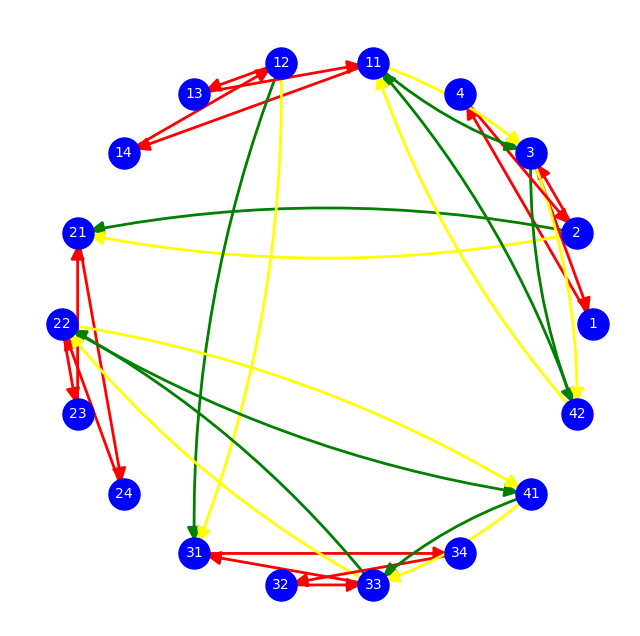

In [189]:
draw_graph(Y2)

If you would like to inspect the connected components of $\beta(Y_1)\otimes_U Y_1$ you would execut the code below.

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

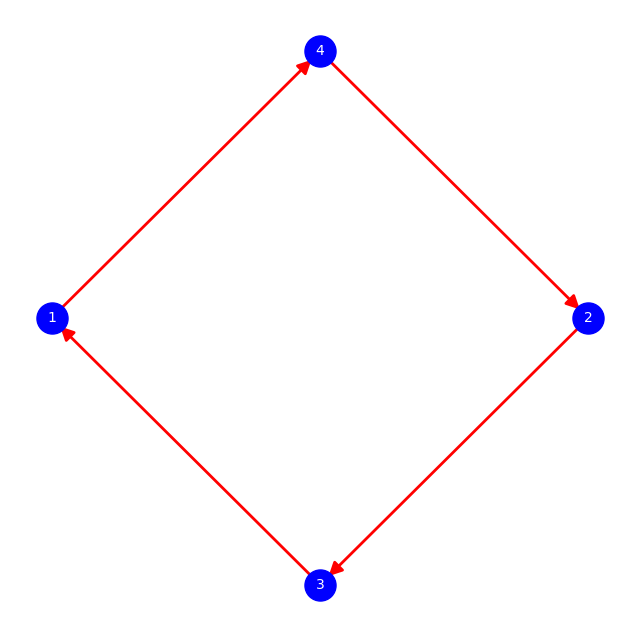

In [191]:
check_fiber(Y4, Y4, image_dict)

In [18]:
check_row_Y4xY4(Y4_x_Y4)

[0, 0, 0, 6, 3, 4, 512]